<a href="https://colab.research.google.com/github/09tangriro/InSight-FYP/blob/master/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

This notebook aims to provide documentation on the Preprocessing Python scripts that can be imported into any project. There are three files in the package: Preprocessing, format and marshht. Preprocessing contains all the functions in this notebook. format and marshht each contain different functions from this notebook, with format designed to take time series data and prepare it for the marshht functions that apply the orthogonal emd process to the data and extracts relevent modes.

In [0]:
!pip install pyhht
!pip install imagesc
import imagesc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy import signal, fftpack
from scipy.signal import hilbert
from sklearn.decomposition import PCA
from math import log, pi, sqrt, floor, ceil
from datetime import datetime as d, timedelta
from pyhht import emd, utils, visualization
from librosa import filters
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data should be split into the VBB and SP data for a particular Sol and passed to a Pandas dataframe. If interfacing with Matlab, the easiest way to do this is to export the Matlab data as a CSV and then import the CSV files into Python.

In [0]:
data_vbb = pd.read_csv('/content/drive/My Drive/FYP/FYPdata/Raw/VBB_data.txt')
data_sp = pd.read_csv('/content/drive/My Drive/FYP/FYPdata/Raw/SP_data.txt')
print(data_sp)
print(data_vbb)

                                t      sp_z      sp_n      sp_e
0        2019-Feb-16 09:57:39.466  0.001251  0.000009  0.000111
1        2019-Feb-16 09:57:39.476  0.001244  0.000014  0.000109
2        2019-Feb-16 09:57:39.485  0.001258  0.000021  0.000105
3        2019-Feb-16 09:57:39.496  0.001244  0.000018  0.000111
4        2019-Feb-16 09:57:39.506  0.001249  0.000005  0.000109
...                           ...       ...       ...       ...
5549588  2019-Feb-17 01:22:35.323  0.001245  0.000013  0.000107
5549589  2019-Feb-17 01:22:35.333  0.001257  0.000015  0.000110
5549590  2019-Feb-17 01:22:35.343  0.001246  0.000016  0.000110
5549591  2019-Feb-17 01:22:35.353  0.001256  0.000013  0.000107
5549592  2019-Feb-17 01:22:35.363  0.001246  0.000014  0.000109

[5549593 rows x 4 columns]
                                t     vbb_z     vbb_n     vbb_e
0        2019-Feb-16 09:57:39.466  0.000179  0.000116 -0.000017
1        2019-Feb-16 09:57:39.476  0.000177  0.000123 -0.000019
2        201

Label data should also be imported as a Pandas dataframe.

In [0]:
date = ['2019-02-16','2019-06-14', '2019-03-07']
label_data = pd.read_csv('/content/drive/My Drive/FYP/FYPdata/Label Data/Label Dates 2019-02-16')
print(label_data)

                   From                   To
0   2019-02-16 06:05:22  2019-02-16 06:05:22
1   2019-02-16 10:08:21  2019-02-16 10:08:23
2   2019-02-16 10:19:38  2019-02-16 10:19:40
3   2019-02-16 10:22:49  2019-02-16 10:22:57
4   2019-02-16 10:32:20  2019-02-16 10:32:25
..                  ...                  ...
81  2019-02-16 23:11:56  2019-02-16 23:11:58
82  2019-02-16 23:20:10  2019-02-16 23:20:11
83  2019-02-16 23:26:16  2019-02-16 23:26:18
84  2019-02-16 23:27:43  2019-02-16 23:27:44
85  2019-02-16 23:44:04  2019-02-16 23:44:06

[86 rows x 2 columns]


# Format

The following functions are all defined in the format script.

The purpose of the combine script is to merge the SP and VBB data into a single data structure as well as providing a column for the target labels.

In [0]:
def combine(data1,data2):
    data1 = data1.to_numpy()
    data2 = data2.to_numpy()
    assert len(data1) == len(data2)
    combined_data = np.zeros(shape = (len(data1),4), dtype='O')
    for i,row in enumerate(data1):
        combined_data[i][0] = row[0] 
        combined_data[i][1] = data1[i][1] + data2[i][1]
        combined_data[i][2] = data1[i][2] + data2[i][2]
        combined_data[i][3] = data1[i][3] + data2[i][3]

    df = {'t': [vec[0] for vec in combined_data], 'Z': [vec[1] for vec in combined_data], 
         'N': [vec[2] for vec in combined_data], 'E': [vec[3] for vec in combined_data], 
         'Label': [0 for vec in combined_data]} 
    df_result = pd.DataFrame(data = df)

    return df_result
time_data_before_labelling = combine(data_sp, data_vbb)
print(time_data_before_labelling)

                                t         Z         N         E  Label
0        2019-Feb-16 09:57:39.466  0.001431  0.000125  0.000094      0
1        2019-Feb-16 09:57:39.476  0.001421  0.000137  0.000090      0
2        2019-Feb-16 09:57:39.485  0.001434  0.000160  0.000084      0
3        2019-Feb-16 09:57:39.496  0.001424  0.000143  0.000093      0
4        2019-Feb-16 09:57:39.506  0.001426  0.000113  0.000094      0
...                           ...       ...       ...       ...    ...
5549588  2019-Feb-17 01:22:35.323  0.001462  0.000029  0.000200      0
5549589  2019-Feb-17 01:22:35.333  0.001472  0.000032  0.000206      0
5549590  2019-Feb-17 01:22:35.343  0.001463  0.000033  0.000207      0
5549591  2019-Feb-17 01:22:35.353  0.001472  0.000029  0.000199      0
5549592  2019-Feb-17 01:22:35.363  0.001462  0.000030  0.000203      0

[5549593 rows x 5 columns]


In [0]:
def plot_graphs(data, col, nperseg,fs=100, plot=True):
    if plot == True:
      plt.rcParams["figure.figsize"] = (8,4)
      plt.plot(data[col])
      plt.xlabel('No. Samples')
      plt.ylabel('Acceleration[ms^-2]')
      plt.show()

    f, t, Sxx = signal.spectrogram(x = data[col], fs = fs,
                                  window = 'hann', nperseg = nperseg,
                                  noverlap = 0.5*nperseg)
    logSxx = np.log10(np.sqrt(Sxx))
    if plot==True:
      fig, ax = plt.subplots()
      spec = ax.pcolormesh(t, f, logSxx, cmap = 'jet', vmin=-9.5,vmax = -6)
      fig.colorbar(spec)
      plt.xlabel('Time (s)')
      #plt.yscale('symlog')
      plt.ylabel('Frequency[Hz]')
      plt.title('Time Series '+col+' Axis')
      plt.savefig('Spectrogram.eps', format='eps')
      plt.show()

    return logSxx

Find and separate the event data:

In [0]:
def binary_search(dates, date, acc = 5):
  n = len(dates)
  L = 0
  R = n-1

  #acc represents a precision value. search for the date in a certain date_range.
  #A lower acc -> more precise but less consistent results 
  #(possible to never find the value due to discrete nature of data).
  date_range = [date+timedelta(milliseconds=acc)-
                timedelta(milliseconds=x) for x in range(2*acc)]

  while L <= R:
    mid = floor((L+R)/2)
    if d.strptime(dates[mid], '%Y-%b-%d %H:%M:%S.%f') in date_range:
      return mid
    elif d.strptime(dates[mid], '%Y-%b-%d %H:%M:%S.%f') < date:
      L = mid+1
    elif d.strptime(dates[mid], '%Y-%b-%d %H:%M:%S.%f') > date:
      R = mid - 1
  return -1

def get_events(time_data, label_data, frame=0, lim=0, label = 1, false_events = []):
  n = len(time_data)
  event_data = []
  label_data = label_data.to_numpy()
  for i,r in enumerate(label_data):
    date_from = d.strptime(r[0], '%Y-%m-%d %H:%M:%S')
    date_to = d.strptime(r[1], '%Y-%m-%d %H:%M:%S')
    if date_from >= d.strptime(time_data['t'][0], '%Y-%b-%d %H:%M:%S.%f') and date_to <= d.strptime(time_data['t'][n-1], '%Y-%b-%d %H:%M:%S.%f'):
      pos1 = binary_search(time_data['t'], date_from)
      pos2 = binary_search(time_data['t'], date_to)
      if pos2-pos1 >= lim and i not in false_events:
        if frame == 0:
          event_data.append(time_data.loc[pos1:pos2, ['Z','N','E']])
          time_data.loc[pos1:pos2, 'Label'] = 1
        else:
          assert type(frame)==int
          event_data.append(time_data.loc[pos1-frame:pos1+(2*frame), ['Z','N','E']])
          time_data.loc[pos1-frame:pos1+(2*frame), 'Label'] = 1
  return event_data, time_data

#[13,14,25,26,28,31,33,34,41,46,53,54,63,69,80,84]
donk_data,time_data = get_events(time_data_before_labelling, label_data,frame=500,false_events=[13,14,25,26,28,31,33,34,41,46,53,54,63,69,80,84])
print('%i donk events separated!' % len(donk_data))
print(donk_data[0])

69 donk events separated!
              Z         N         E
63654  0.001362  0.000142  0.000093
63655  0.001361  0.000140  0.000096
63656  0.001361  0.000136  0.000095
63657  0.001361  0.000141  0.000093
63658  0.001362  0.000142  0.000094
...         ...       ...       ...
65150  0.001363  0.000138  0.000090
65151  0.001355  0.000117  0.000098
65152  0.001357  0.000139  0.000100
65153  0.001367  0.000158  0.000095
65154  0.001358  0.000133  0.000094

[1501 rows x 3 columns]


Find and separate the negative data:

In [0]:
def get_negatives(time_data, n, start = 0, N = 500, label = 0):
  neg_data = time_data.loc[time_data['Label']==label]
  neg_data = neg_data.drop('t', axis=1)
  neg_data = neg_data.drop('Label',axis=1)
  neg_data_arr = neg_data.to_numpy()
  index_l = neg_data.index.to_list()
  res = [None]*n
  for i in range(n):
    data = neg_data_arr[start+(i*N):start+((i*N)+3*N)+1]
    d = {'Z': [vec[0] for vec in data], 'N': [vec[1] for vec in data], 
        'E': [vec[2] for vec in data]} 
    res[i] = pd.DataFrame(data=d)
  return res

neg_data = get_negatives(time_data, len(donk_data),start=1200000)#,start = 1200000 #3200000
print('%i neg events separated!' % len(neg_data))
print(neg_data[0])

69 neg events separated!
             Z         N         E
0     0.000294  0.000088  0.000036
1     0.000296  0.000098  0.000043
2     0.000298  0.000099  0.000045
3     0.000291  0.000075  0.000036
4     0.000295  0.000071  0.000040
...        ...       ...       ...
1496  0.000297  0.000100  0.000015
1497  0.000294  0.000046  0.000017
1498  0.000284  0.000072  0.000075
1499  0.000291  0.000112  0.000079
1500  0.000305  0.000098 -0.000007

[1501 rows x 3 columns]


0


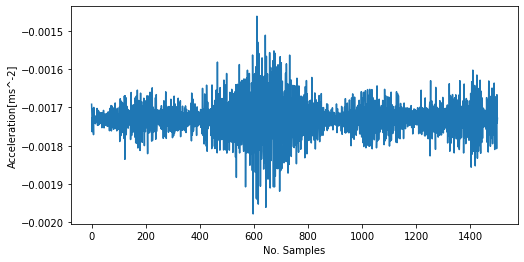

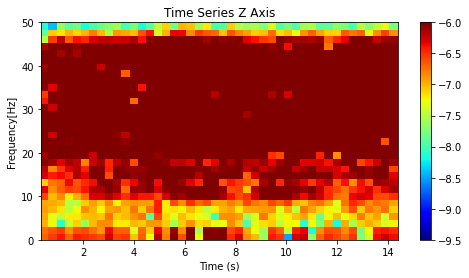

1


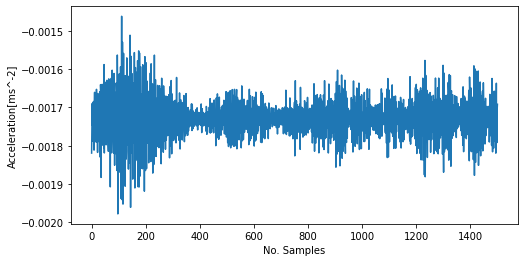

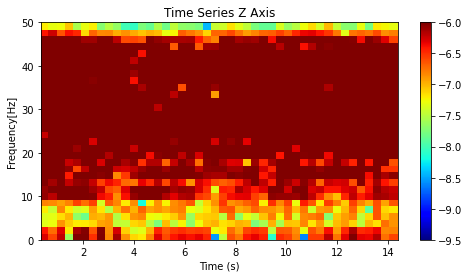

2


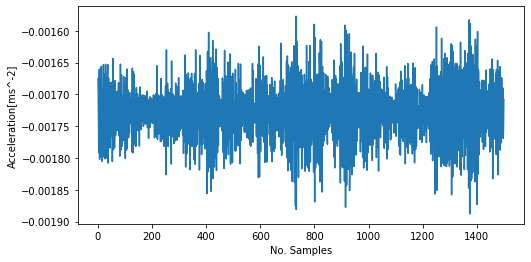

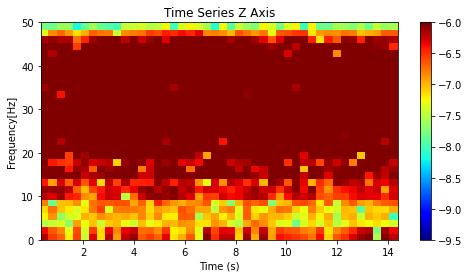

3


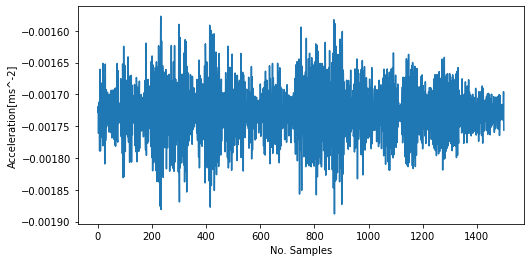

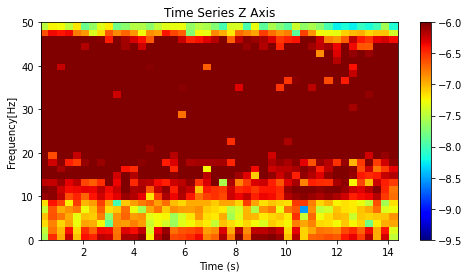

4


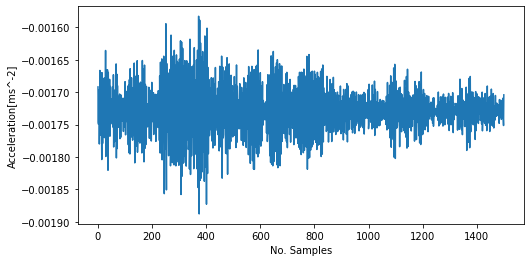

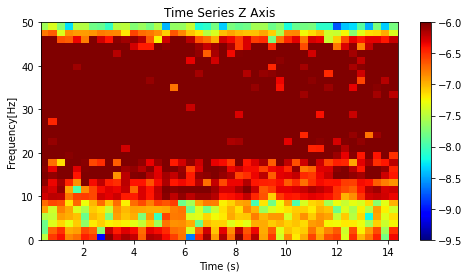

5


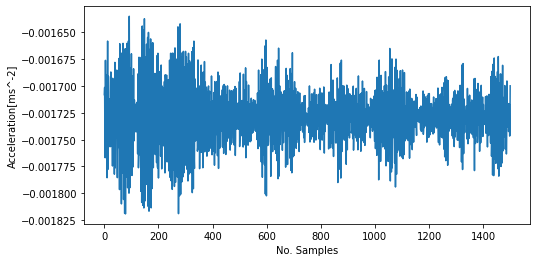

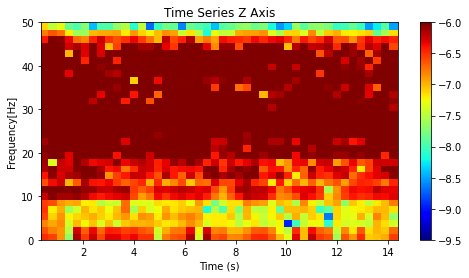

6


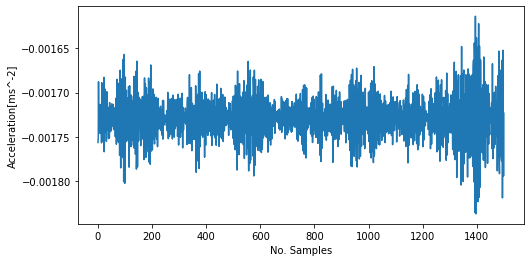

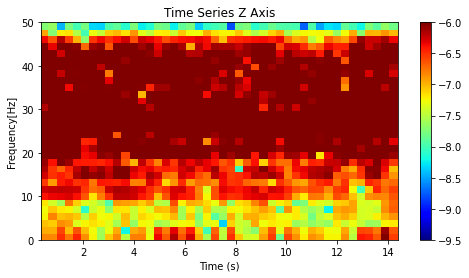

7


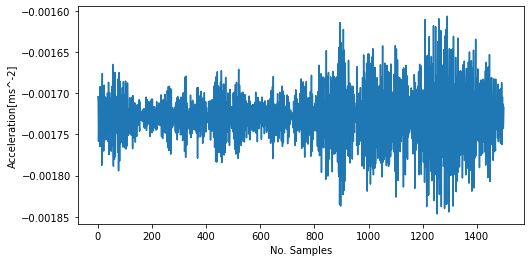

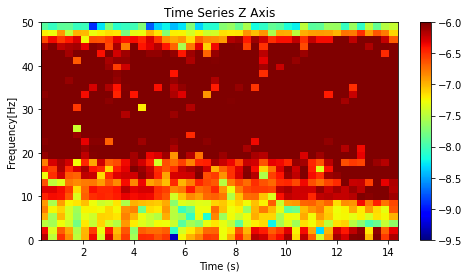

8


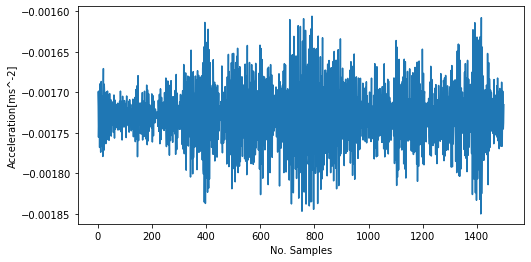

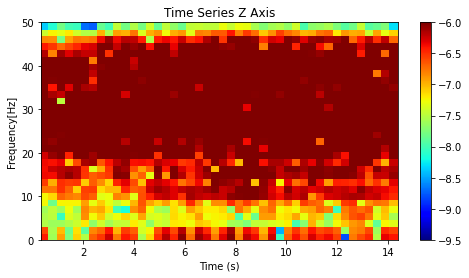

9


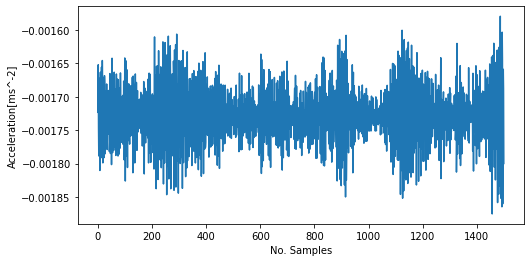

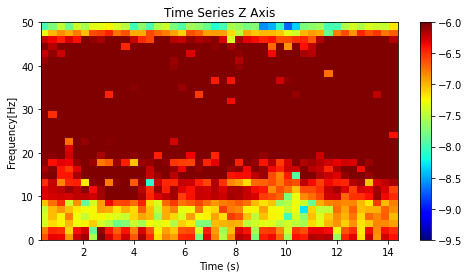

10


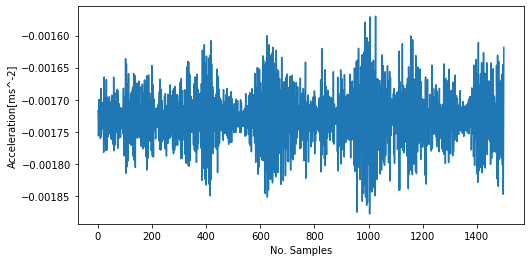

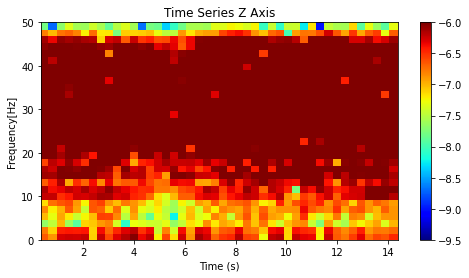

11


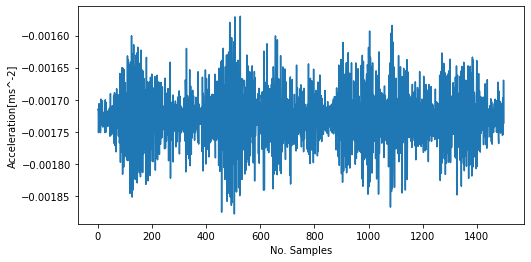

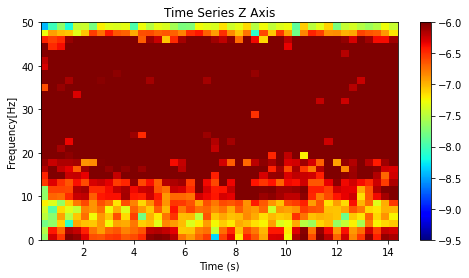

12


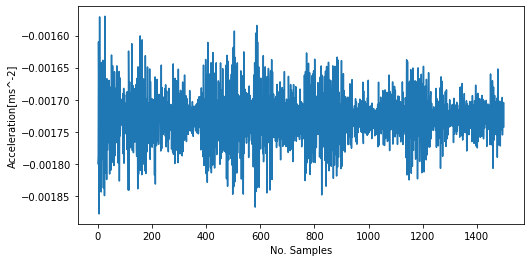

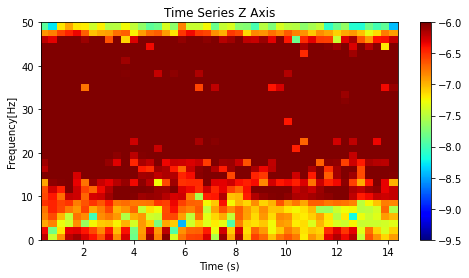

13


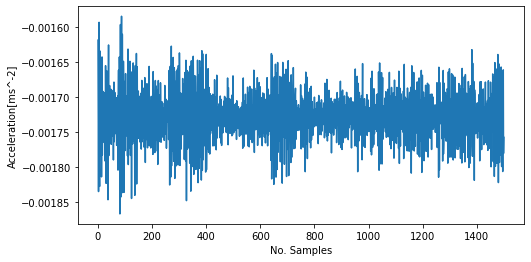

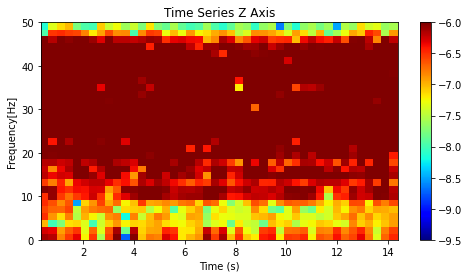

14


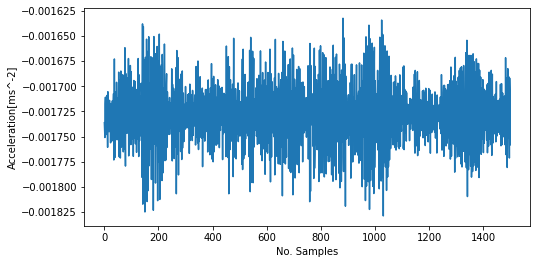

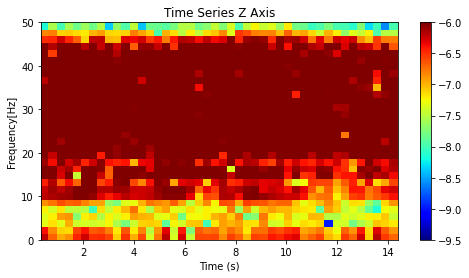

15


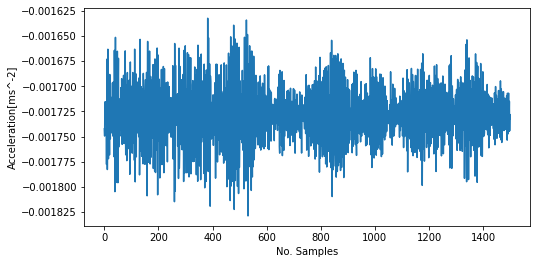

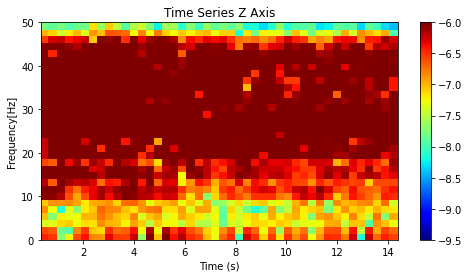

In [0]:
for i,d in enumerate(neg_data):
  print(i)
  A = plot_graphs(d,'Z',64, plot=True)

Generate the target label data for each donk and negative data sample:

In [0]:
def create_target(num_events,num_negs,event_label=1,negative_label=0):
  target_events = np.array([event_label for i in range(num_events)])
  target_negs = np.array([negative_label for i in range(num_negs)])
  target_data = np.concatenate((target_negs,target_events))
  return target_data
target_data = create_target(len(donk_data),len(neg_data))
print(target_data, len(target_data))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 138


Combine the negative and donk data sets into a single feature set:

In [0]:
feature_data = neg_data + donk_data
print(len(feature_data))

138


#MarsHHT

These functions mainly implement the OEMD algorithm as well as some noise reduction through feature extraction.

The EEMD algorithm isn't actually used but its implementation is still here.

In [0]:
def eemd(sig, trials=100, noise_width = 0.05):
  n = len(sig)
  imfs = []
  num_additions = []
  std = noise_width*np.std(sig)
  for i in range(trials):
    noise = np.random.normal(0,std,size=n)
    noisy_sig = np.add(sig,noise)
    decomposer = emd.EMD(noisy_sig)
    noisy_imfs = decomposer.decompose()
    #remove residue!
    noisy_imfs = noisy_imfs[:len(noisy_imfs)-1]
    if i == 0:
      imfs = noisy_imfs.tolist()
      num_additions = [1]*len(imfs)
    else:
      while len(noisy_imfs) > len(imfs):
        imfs.append(0)
        num_additions.append(0)
      for i,imf in enumerate(noisy_imfs):
        imfs[i] = np.add(imfs[i],imf)
        num_additions[i] += 1
  for i,imf in enumerate(imfs):
    imfs[i] = [x / num_additions[i] for x in imf]
  imfs = np.array(imfs)
  return imfs

def plot_imfs(imfs):
  plt.rcParams["figure.figsize"] = (6,4)
  plt.figure
  for i,imf in enumerate(imfs):
    plt.subplot(len(imfs),1,i+1)
    t = np.arange(imfs.shape[1])/10
    plt.plot(t,imf)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [ms^-2]')
    plt.tight_layout()
  plt.show()
 

In [0]:
def emd_postprocessing(eemds):
  num_signals = len(eemds)
  t = len(eemds[0])
  imfs = []
  sum_sig = eemds[0]
  residue = [0]*t
  for i in range(num_signals):
    decomposer = emd.EMD(sum_sig,n_imfs=2)
    imfs_sig = decomposer.decompose()
    if len(imfs_sig) == 1:
      residue = [0]*t
    else:
      residue = imfs_sig[1]
    imfs.append(imfs_sig[0])
    if i < num_signals-1:
      sum_sig = np.add(residue, eemds[i+1])
  decomposer = emd.EMD(np.array(residue),n_imfs=2)
  imfs_sig = decomposer.decompose()
  while(len(imfs_sig) > 1):
    imfs.append(imfs_sig[0])
    decomposer = emd.EMD(imfs_sig[0],n_imfs=2)
    imfs_sig = decomposer.decompose()
  residue = imfs_sig
  imfs = np.array(imfs)
  return imfs,residue

All functions relating to orthogonality:

In [0]:
def IOt(imfs,x):
  dp = np.dot(imfs, np.conj(imfs).T)
  mask = np.logical_not(np.eye(len(imfs)))
  s = np.abs(dp[mask]).sum()
  return s / (2 * np.sum(x ** 2))

def orthogonal_factor(c,d):
  num = np.dot(c,d.T)
  den = np.dot(d,d.T)
  return num/den

def orthogonal_emd(imfs):
  num_imfs = len(imfs)
  t = len(imfs[0])
  res = np.zeros((num_imfs,t))

  for i,imf in enumerate(reversed(imfs)):
    if i == 0:
      res[i] = imf
    else:
      of = np.zeros(shape=(i,))
      f = np.zeros(shape=(i,t))
      for j in range(i):
        of[j] = orthogonal_factor(imf,res[i-(j+1)])
        f[j] = of[j]*res[i-(j+1)]
      d = np.sum(f,axis=0)
      res[i] = np.array([c-d_ for c,d_ in zip(imf,d)])
  return res

All functions relating to the acquisition of instantaneous frequencies for the plotting of the Hilbert Spectrum:

In [0]:
def get_bin(freq,n_bins,bins):
  if freq < 0:
    return -1
  ratio = n_bins/bins[len(bins)-1] 
  index = int(freq*ratio)
  return index

def check_inputs(imfs):
  if len(imfs) < 1:
    return -1
  else: 
    return 1

def get_freq_amp(imf,fs):
  x_a = signal.hilbert(imf)
  p = np.unwrap(np.angle(x_a))
  inst_f = np.diff(p)/(2*np.pi)*fs #diff[i] = a[i+1] - a[i]
  inst_a = np.abs(x_a)[:len(imf)-1] 
  return inst_f,inst_a

def hht(imfs, fs, n_freq=201):
  if len(imfs.shape) == 1:
    t = np.arange(len(imfs)-1)
  else:
    t = np.arange(len(imfs[0])-1)
  f = np.linspace(0,int(fs/2),n_freq)
  A = [[0 for i in range(len(t))] for j in range(len(f))]
  inst_a = [None]*(len(imfs))
  inst_f = [None]*(len(imfs))

  if len(imfs.shape) == 1:
    inst_f,inst_a = get_freq_amp(imfs,fs)
    for i,c in enumerate(inst_a):
      freq = inst_f[i]
      freq_bin = get_bin(freq,n_freq,f)
      if freq_bin != -1:
        A[freq_bin][i] += c
  else:
    for i,imf in enumerate(imfs):
      inst_f[i],inst_a[i] = get_freq_amp(imf,fs)
    for i,r in enumerate(inst_a):
      for j,c in enumerate(r):
        freq = inst_f[i][j]
        freq_bin = get_bin(freq,n_freq,f)
        if freq_bin != -1:
          A[freq_bin][j] += c
  A = np.array(A)
  return A,f,t

def plot_hs(A,f,t):
  A = np.log(A)
  fig, ax = plt.subplots()
  cmap = ax.pcolormesh(t/100, f, A, cmap = 'jet')
  fig.colorbar(cmap)
  plt.title('Hilbert Spectrum Z')
  plt.xlabel('Time [s]')
  plt.ylabel('Frequency[Hz]')
  plt.savefig('reduced_hilbert.pdf', format='pdf')
  plt.show(fig)



Feature extraction methods:

In [0]:
def get_corr(sig,imfs):
  res = [None]*len(imfs)
  for i,imf in enumerate(imfs):
    res[i] = abs(np.corrcoef(imf,sig)[0,1])
  return res

def get_threshold(corr_coefs):
  return max(corr_coefs)/(10*max(corr_coefs)-3)

def filter_imfs(corr_coefs, threshold, imfs):
  res = []
  for i,corr in enumerate(corr_coefs):
    if corr > threshold:
      res.append(imfs[i])
  res = np.array(res)
  return res

In [0]:
def get_coeffs(A,num_ceps=13,num_filters=16,f_bins=400,fs=100,normalize=True,corr=False):
  fbank = filters.mel(fs,f_bins,num_filters, norm=None)
  fbank_coeffs = np.dot(fbank,A).T
  mfcc = fftpack.dct(fbank_coeffs, type=2, norm='ortho')[:, 1 : (num_ceps + 1)]
  if normalize == True:
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    fbank_coeffs -= (np.mean(fbank_coeffs, axis=0) + 1e-8)
  if corr == False:
    return mfcc
  else:
    return fbank_coeffs

In [0]:
def plot_coeffs(coeffs):
  t = np.arange(coeffs.shape[0])
  t = t*(15/len(t))
  mel = np.arange(coeffs.shape[1])
  coeffs = coeffs.T
  cmap = plt.pcolormesh(t, mel, coeffs, cmap = 'jet')
  plt.colorbar(cmap)
  plt.xlabel('Time (s)')
  plt.ylabel('Coefficient')
  #plt.show()


In [0]:
def delta(feat, N=2):
    M = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = np.empty_like(feat)
    padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(M):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat
    

#Sandbox

Play around with different features!

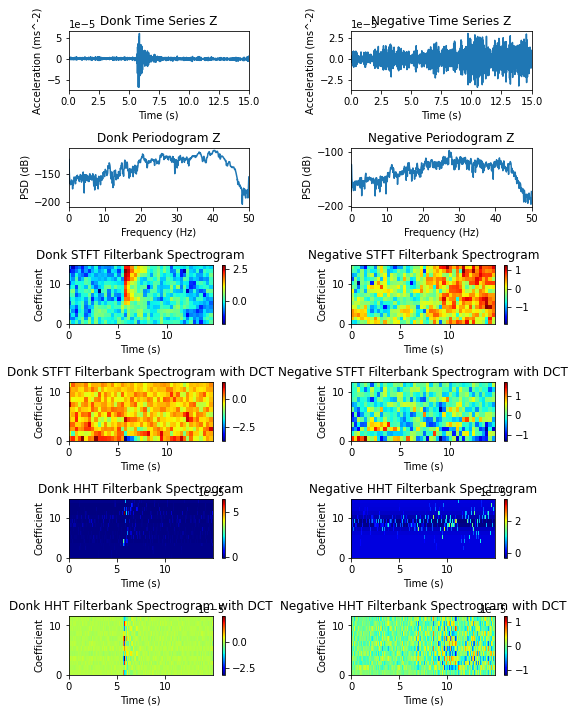

In [0]:
def normalize(data):
  for j,ax in enumerate(s):
    data[j] -= np.mean(data[j])
  return data


time_data_donk = donk_data[0].to_numpy().T
time_data_donk = np.array(time_data_donk)
time_data_donk = normalize(time_data_donk)


time_data_neg = neg_data[0].to_numpy().T
time_data_neg = np.array(time_data_neg)
time_data_neg = normalize(time_data_neg)

f1,pxx_donk = signal.periodogram(donk_data[0]['Z'],100,'hann')
pxx_donk = 10*np.log10(pxx_donk)

f,pxx_neg = signal.periodogram(neg_data[0]['Z'],100,'hann')
pxx_neg = 10*np.log10(pxx_neg)

A = plot_graphs(donk_data[0],'Z',64,plot=False)
fbank_coeffs_donk_stft = get_coeffs(A,f_bins=64,corr=True,normalize=True)

A = plot_graphs(neg_data[0],'Z',64,plot=False)
fbank_coeffs_neg_stft = get_coeffs(A,f_bins=64,corr=True,normalize=True)

A = plot_graphs(donk_data[0],'Z',64,plot=False)
cepstral_coeffs_donk_stft = get_coeffs(A,f_bins=64,corr=False,normalize=True)

A = plot_graphs(neg_data[0],'Z',64,plot=False)
cepstral_coeffs_neg_stft = get_coeffs(A,f_bins=64,corr=False,normalize=True)

decomposer = emd.EMD(donk_data[0]['Z'])
imfs = decomposer.decompose()
oimfs = orthogonal_emd(imfs)
oimfs = oimfs[1:]
corrs = get_corr(donk_data[0]['Z'],oimfs)
thresh = get_threshold(corrs)
res_imfs = filter_imfs(corrs,thresh,oimfs)
A,f,t = hht(res_imfs,100)
fbank_coeffs_donk_hht = get_coeffs(A,corr=True)

decomposer = emd.EMD(neg_data[0]['Z'])
imfs = decomposer.decompose()
oimfs = orthogonal_emd(imfs)
oimfs = oimfs[1:]
corrs = get_corr(neg_data[0]['Z'],oimfs)
thresh = get_threshold(corrs)
res_imfs = filter_imfs(corrs,thresh,oimfs)
A,f,t = hht(res_imfs,100)
fbank_coeffs_neg_hht = get_coeffs(A,corr=True)

decomposer = emd.EMD(donk_data[0]['Z'])
imfs = decomposer.decompose()
oimfs = orthogonal_emd(imfs)
oimfs = oimfs[1:]
corrs = get_corr(donk_data[0]['Z'],oimfs)
thresh = get_threshold(corrs)
res_imfs = filter_imfs(corrs,thresh,oimfs)
A,f,t = hht(res_imfs,100)
cepstral_coeffs_donk_hht = get_coeffs(A,corr=False)

decomposer = emd.EMD(neg_data[0]['Z'])
imfs = decomposer.decompose()
oimfs = orthogonal_emd(imfs)
oimfs = oimfs[1:]
corrs = get_corr(neg_data[0]['Z'],oimfs)
thresh = get_threshold(corrs)
res_imfs = filter_imfs(corrs,thresh,oimfs)
A,f,t = hht(res_imfs,100)
cepstral_coeffs_neg_hht = get_coeffs(A,corr=False)

plt.rcParams["figure.figsize"] = (8,10)
t = (np.arange(1501).T)/100

plt.figure
plt.subplot(6,2,1)
plt.plot(t,time_data_donk[0])
plt.title('Donk Time Series Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (ms^-2)')
plt.xlim(0,15)
plt.tight_layout()

plt.subplot(6,2,2)
plt.plot(t,time_data_neg[0])
plt.title('Negative Time Series Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (ms^-2)')
plt.xlim(0,15)
plt.tight_layout()

plt.subplot(6,2,3)
plt.plot(f1,pxx_donk)
plt.title('Donk Periodogram Z')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.xlim(0,50)
plt.tight_layout()

plt.subplot(6,2,4)
plt.plot(f1,pxx_neg)
plt.title('Negative Periodogram Z')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.xlim(0,50)
plt.tight_layout()

plt.subplot(6,2,5)
plot_coeffs(fbank_coeffs_donk_stft)
plt.title('Donk STFT Filterbank Spectrogram')
plt.tight_layout()

plt.subplot(6,2,6)
plot_coeffs(fbank_coeffs_neg_stft)
plt.title('Negative STFT Filterbank Spectrogram')
plt.tight_layout()

plt.subplot(6,2,7)
plot_coeffs(cepstral_coeffs_donk_stft)
plt.title('Donk STFT Filterbank Spectrogram with DCT')
plt.tight_layout()

plt.subplot(6,2,8)
plot_coeffs(cepstral_coeffs_neg_stft)
plt.title('Negative STFT Filterbank Spectrogram with DCT')
plt.tight_layout()

plt.subplot(6,2,9)
plot_coeffs(fbank_coeffs_donk_hht)
plt.title('Donk HHT Filterbank Spectrogram')
plt.tight_layout()

plt.subplot(6,2,10)
plot_coeffs(fbank_coeffs_neg_hht)
plt.title('Negative HHT Filterbank Spectrogram')
plt.tight_layout()

plt.subplot(6,2,11)
plot_coeffs(cepstral_coeffs_donk_hht)
plt.title('Donk HHT Filterbank Spectrogram with DCT')
plt.tight_layout()

plt.subplot(6,2,12)
plot_coeffs(cepstral_coeffs_neg_hht)
plt.title('Negative HHT Filterbank Spectrogram with DCT')
plt.tight_layout()

plt.savefig('feature_data.eps',format='eps')
plt.show()

Let's just look at a single donk and negative feature on the Z axis:

Orthogonallity before =  4.558919532153165e-05
Orthogonality after =  3.331012715049659e-20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


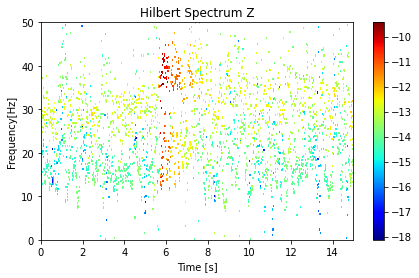

In [0]:
donk = donk_data[0]['Z']
neg = neg_data[0]['Z']

#pass donk or neg to EMD
decomposer = emd.EMD(donk)
imfs = decomposer.decompose()

print('Orthogonallity before = ',decomposer.io())
oimfs = orthogonal_emd(imfs)
print('Orthogonality after = ', IOt(oimfs,donk))

#remove residue
oimfs = oimfs[1:]

#uncomment these two lines to see the Hilbert Spectrum
#of the orthogonal IMFs.
#A,f,t = hht(oimfs,100)
#plot_hs(A,f,t)

corrs = get_corr(donk,oimfs)
thresh = get_threshold(corrs)
res_imfs = filter_imfs(corrs,thresh,oimfs)
#plot_imfs(res_imfs)
A,f,t = hht(res_imfs,100)
#plt.rcParams["figure.figsize"] = (7,4)
plot_hs(A,f,t)

#Feauture reduction:
#fbank_coeffs = get_coeffs(A,corr=False,normalize=True)
#plot_coeffs(fbank_coeffs)


Get Periodogram features:

In [0]:
N = len(feature_data)
res = [[[None],[None],[None]] for i in range(len(feature_data))]
for i,d in enumerate(feature_data):
  for j,ax in enumerate(d):
    f,pxx = signal.periodogram(d[ax],100,'hann')
    pxx = 10*np.log10(pxx)
    #plt.plot(pxx)
    #plt.show()
    res[i][j] = pxx
res = np.array(res)
print(res.shape)

(54, 3, 751)


Get STFT features:

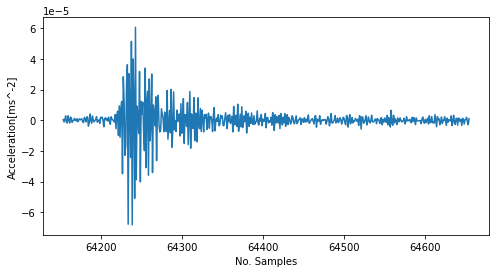

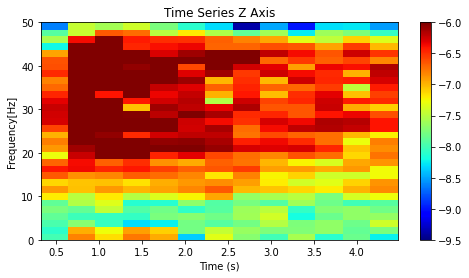

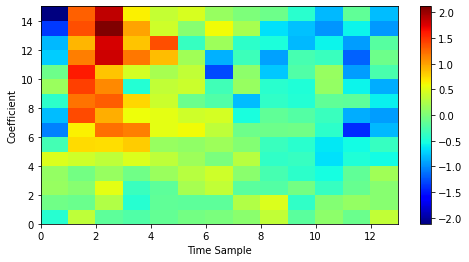

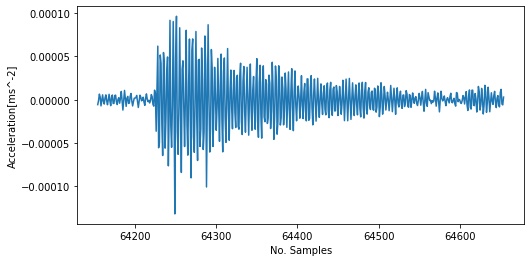

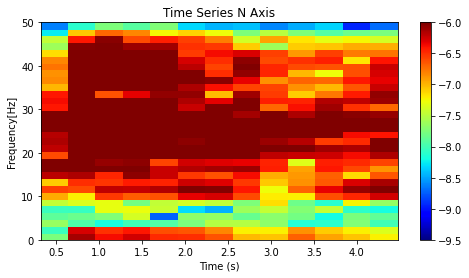

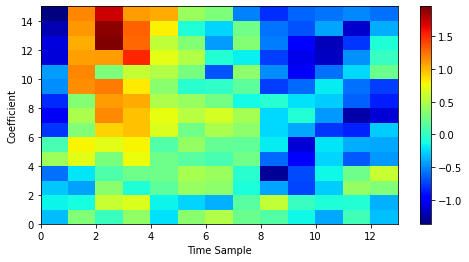

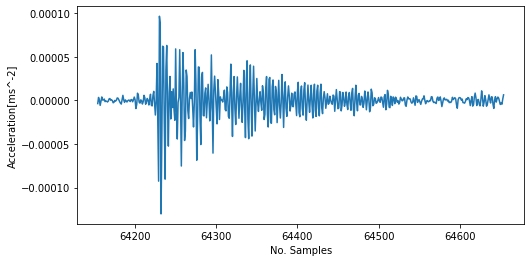

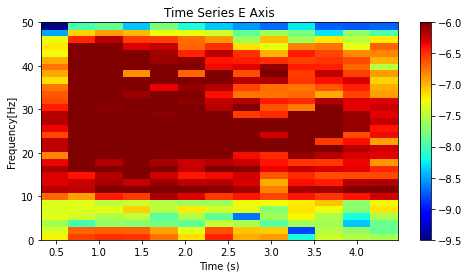

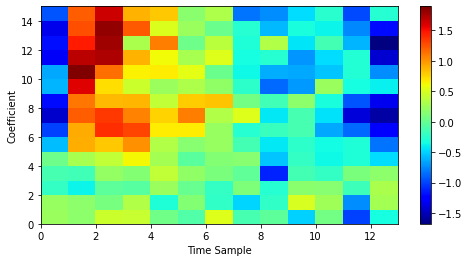

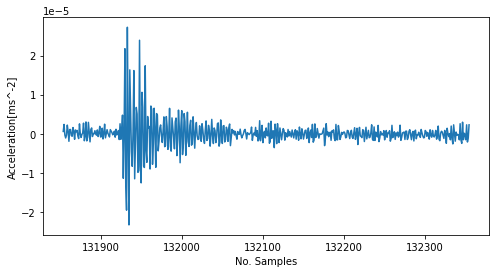

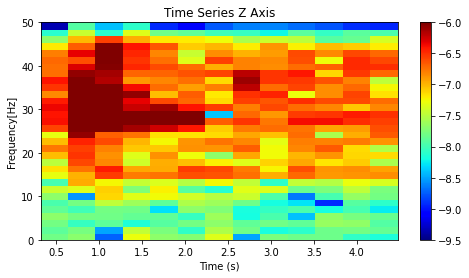

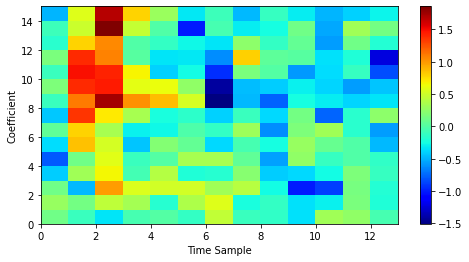

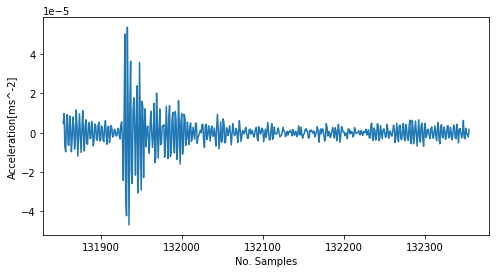

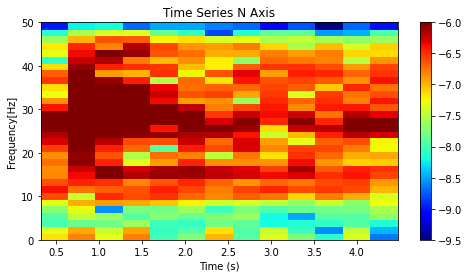

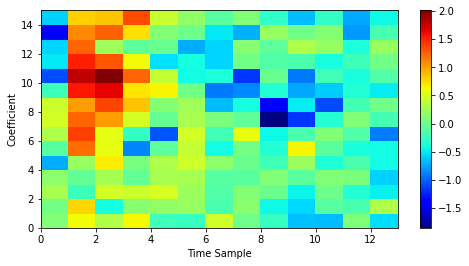

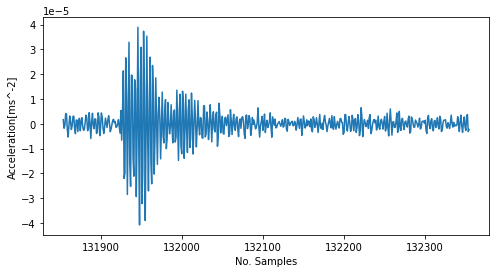

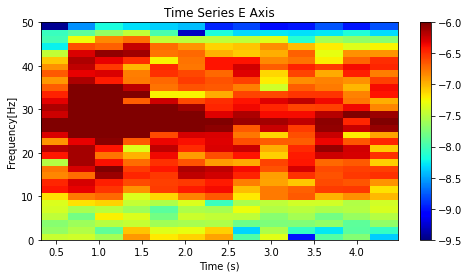

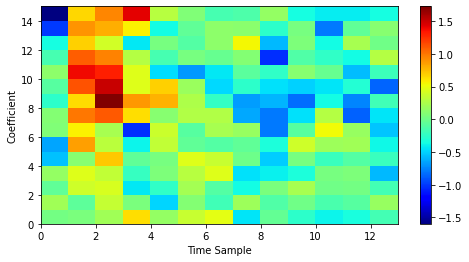

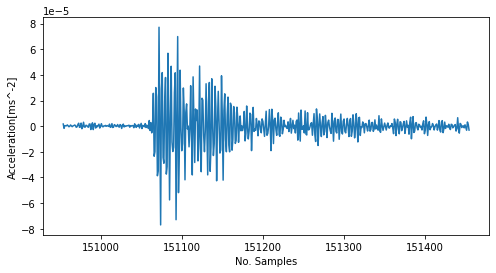

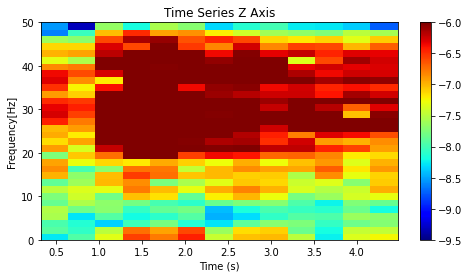

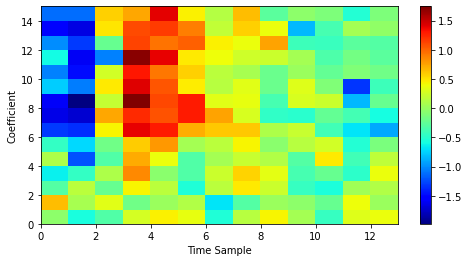

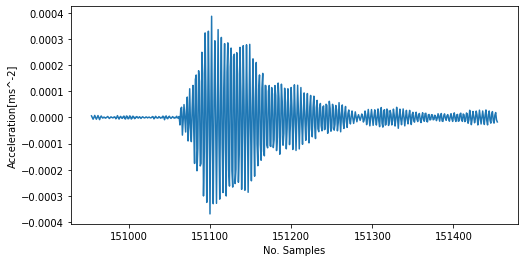

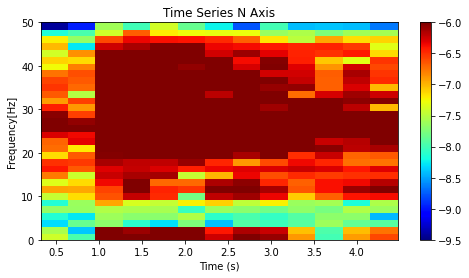

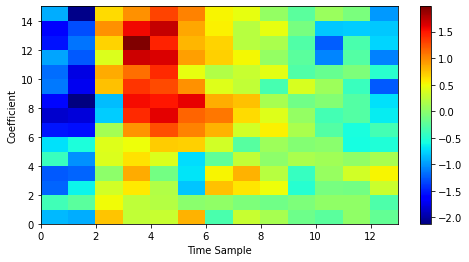

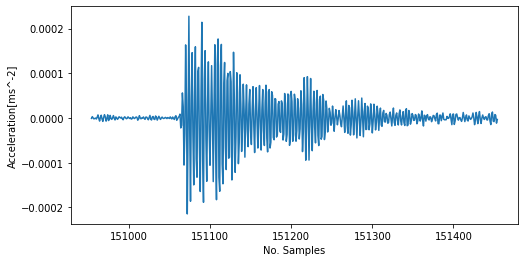

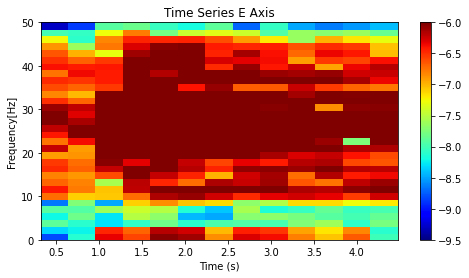

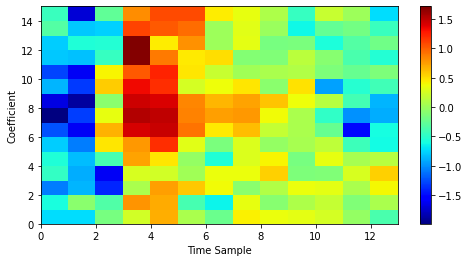

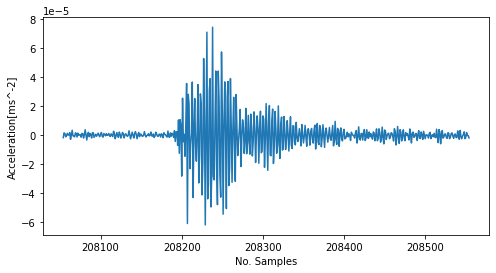

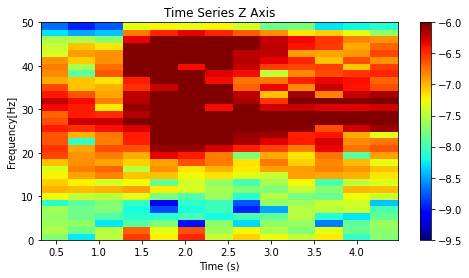

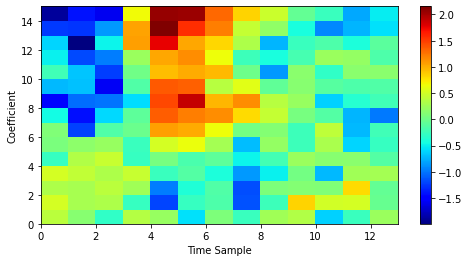

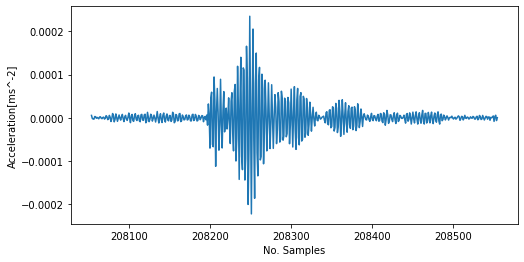

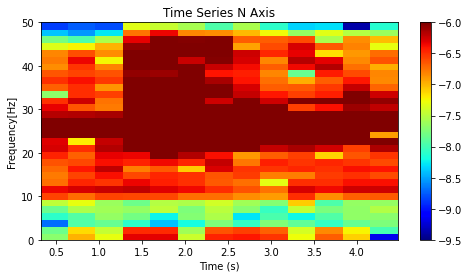

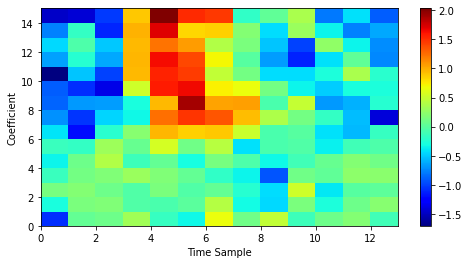

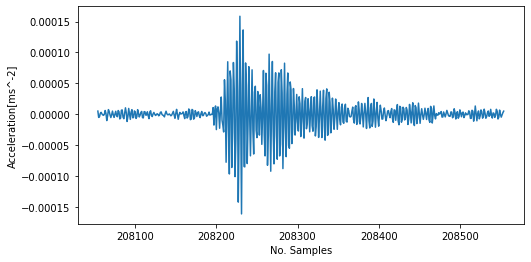

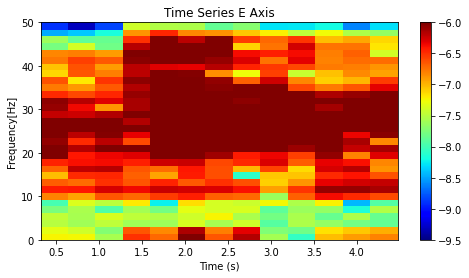

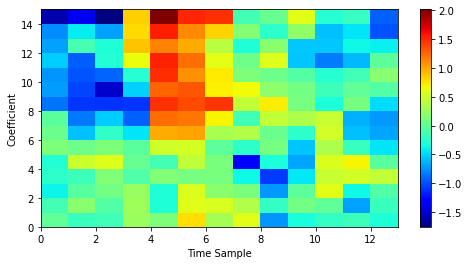

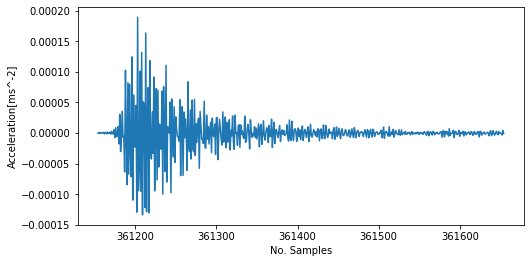

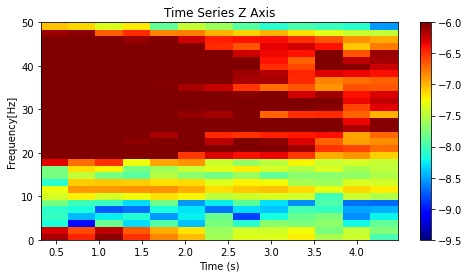

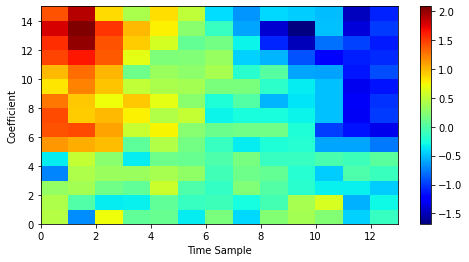

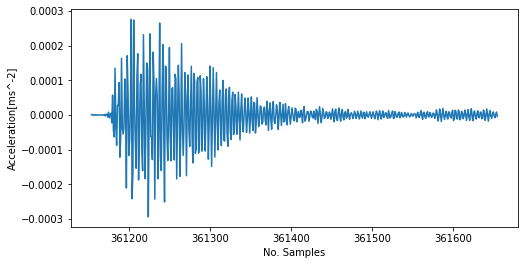

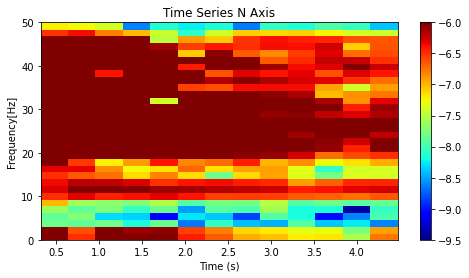

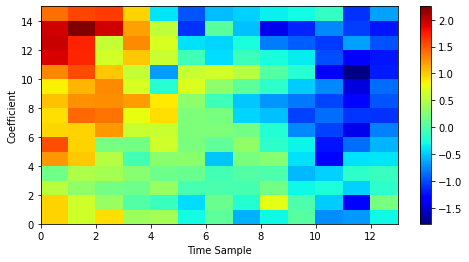

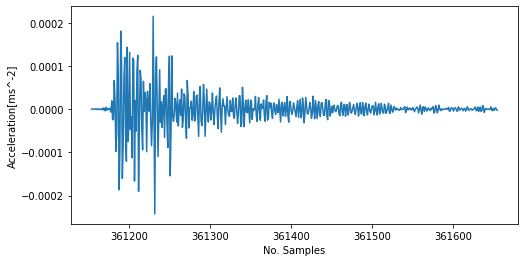

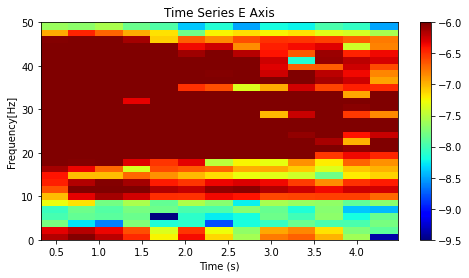

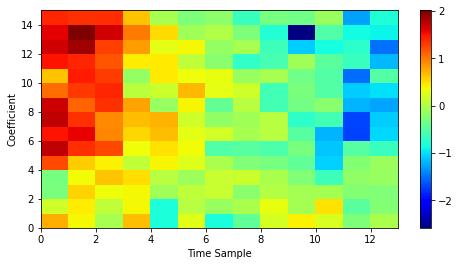

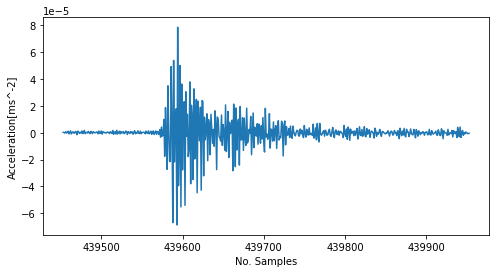

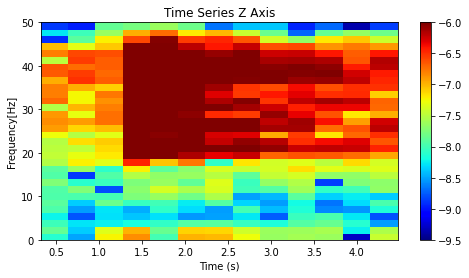

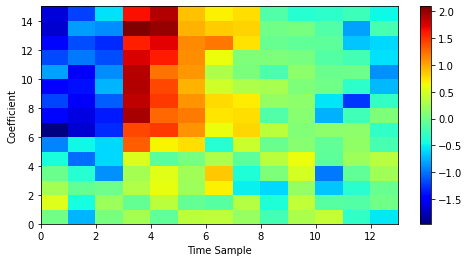

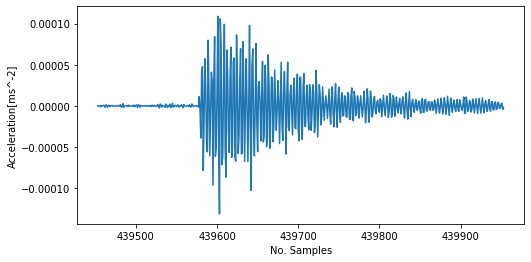

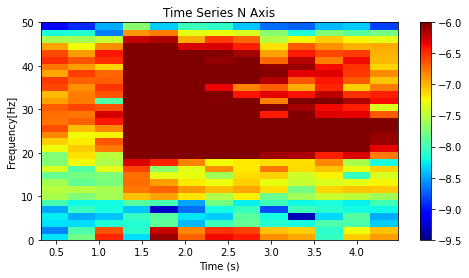

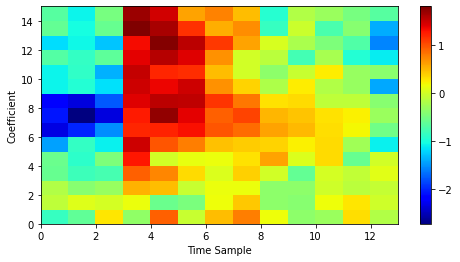

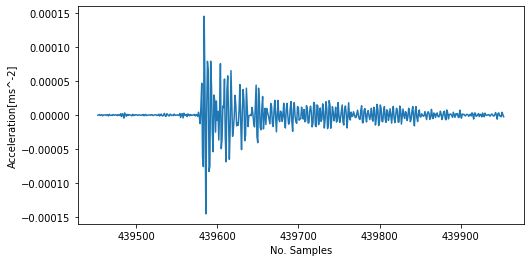

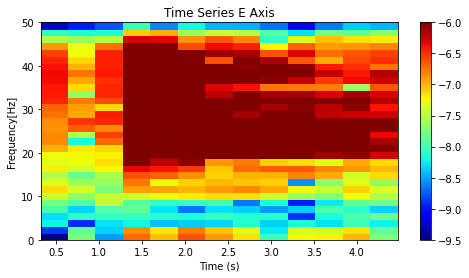

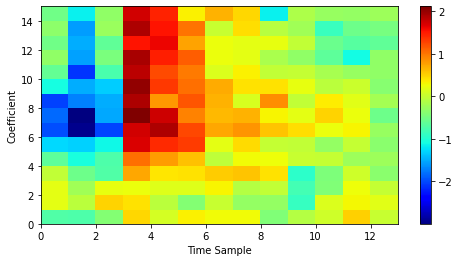

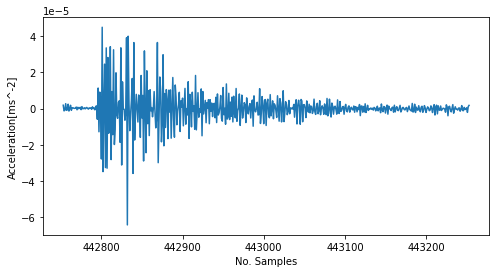

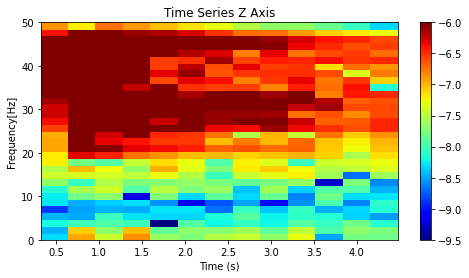

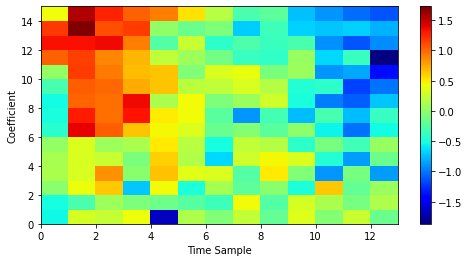

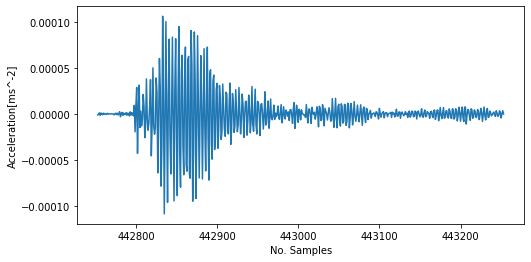

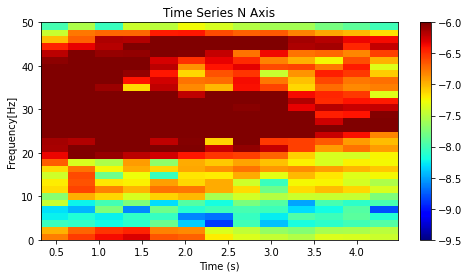

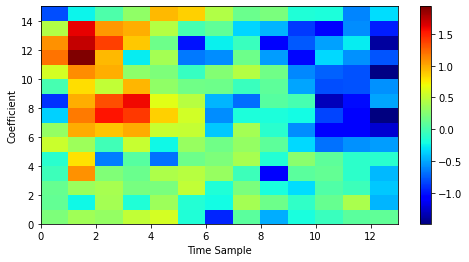

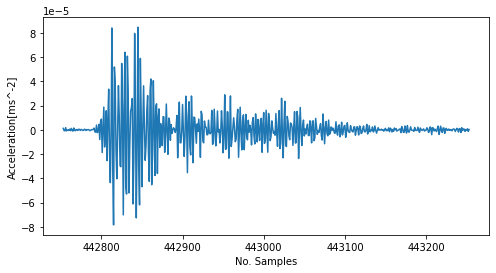

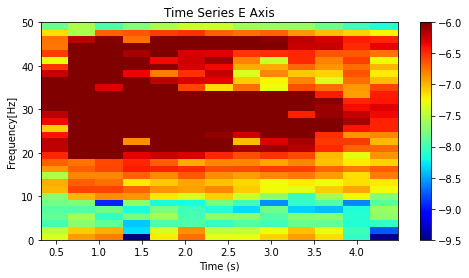

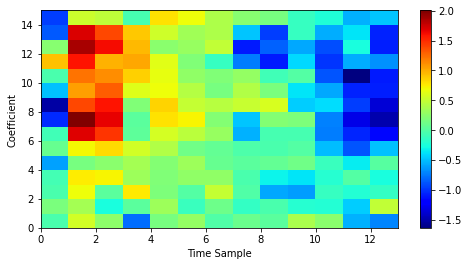

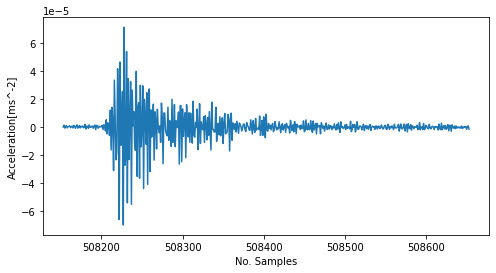

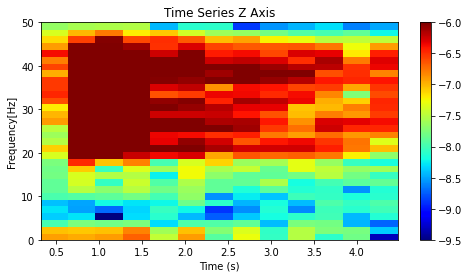

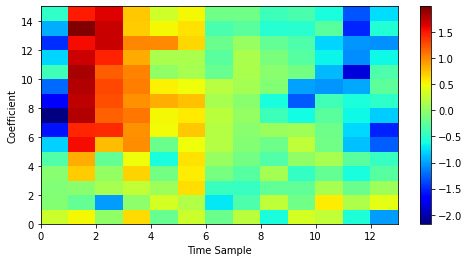

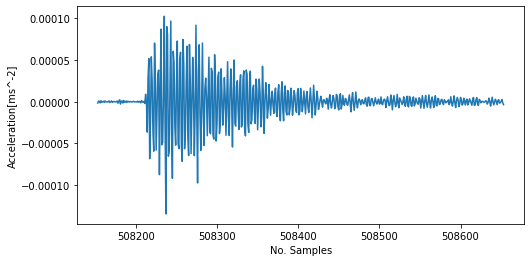

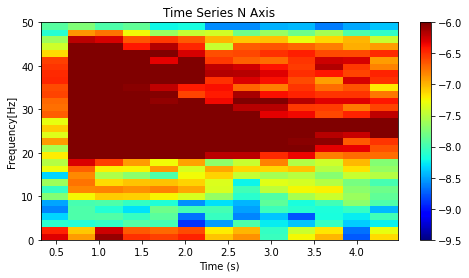

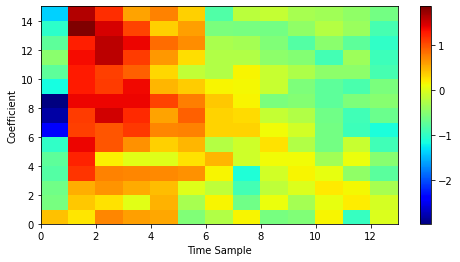

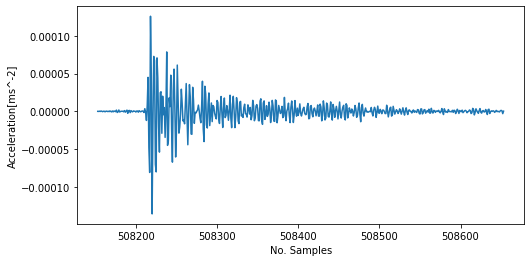

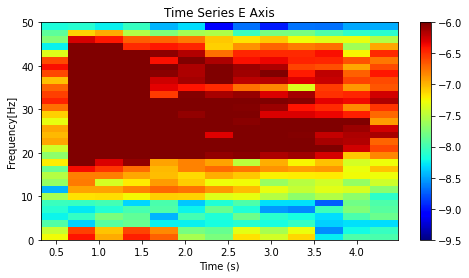

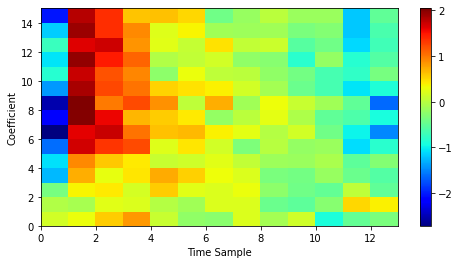

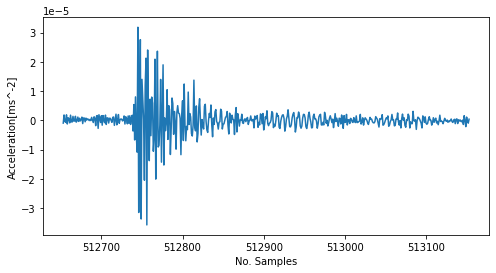

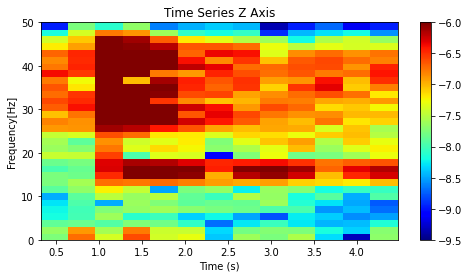

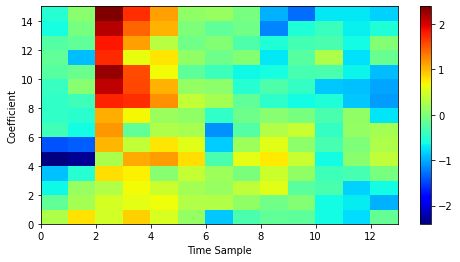

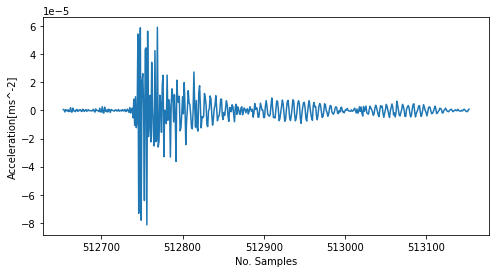

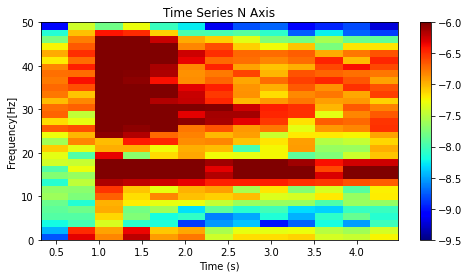

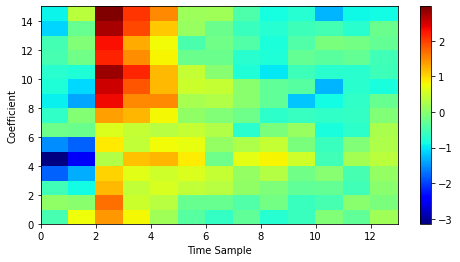

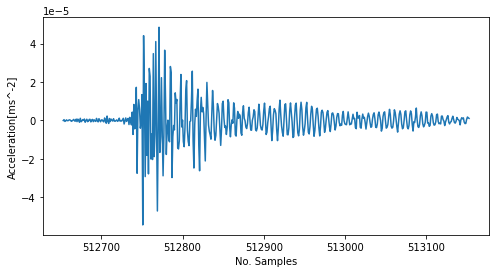

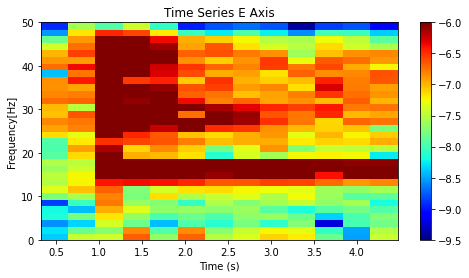

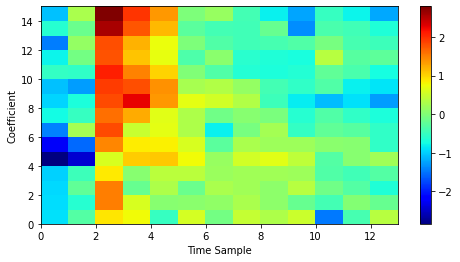

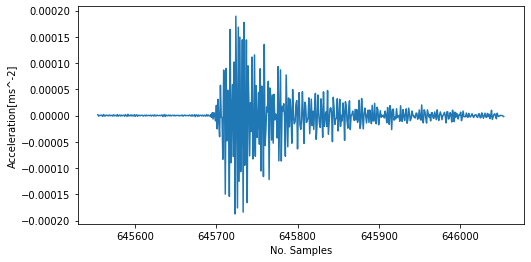

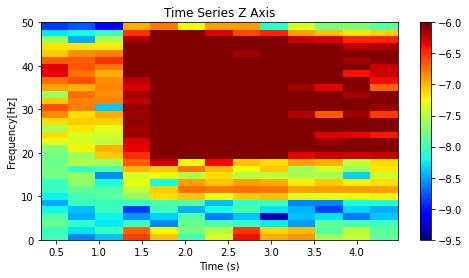

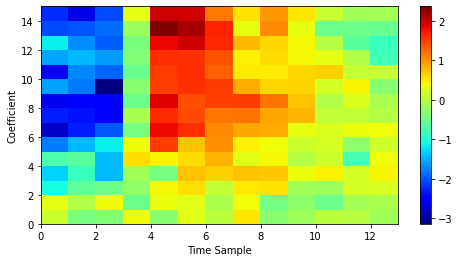

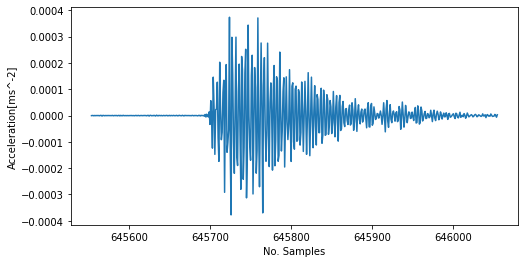

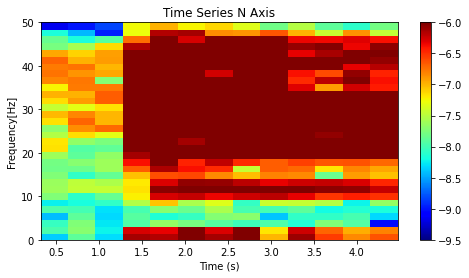

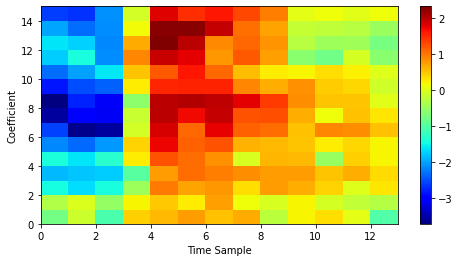

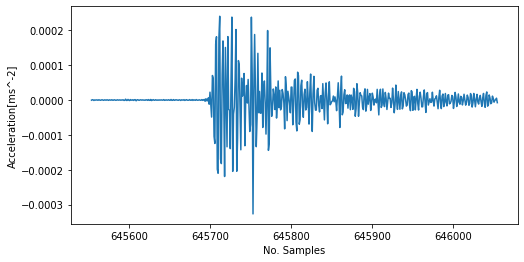

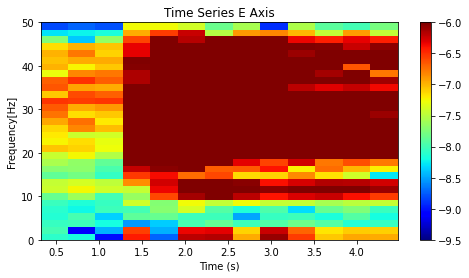

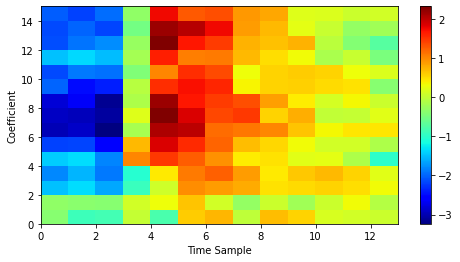

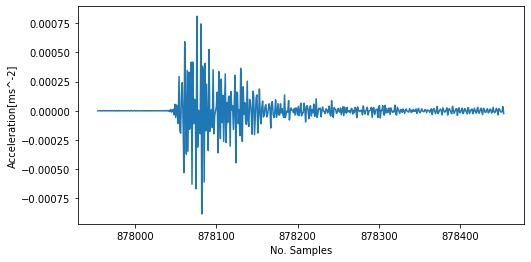

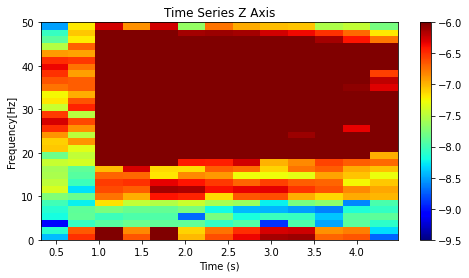

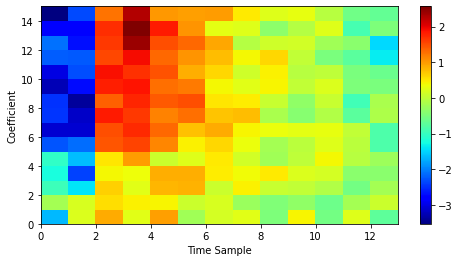

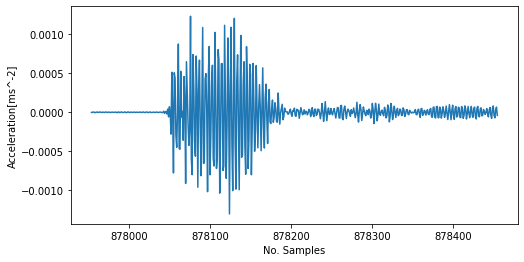

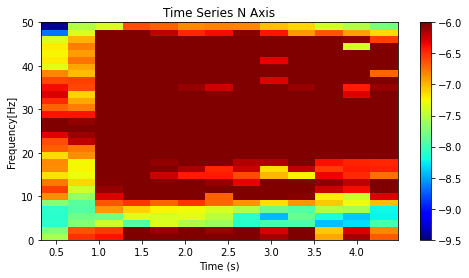

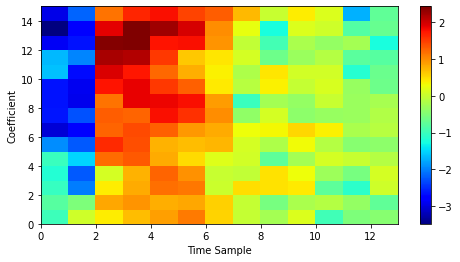

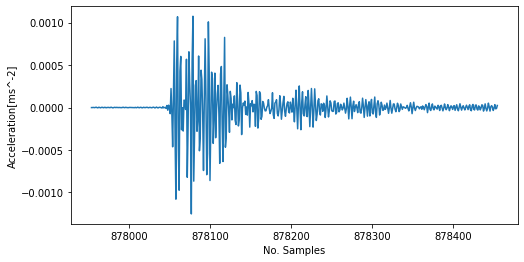

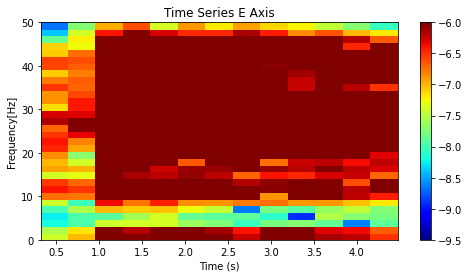

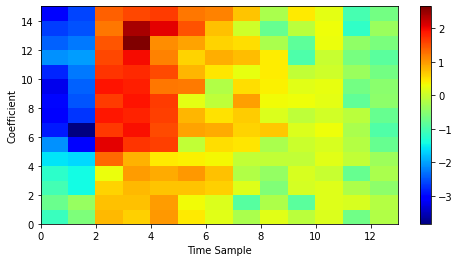

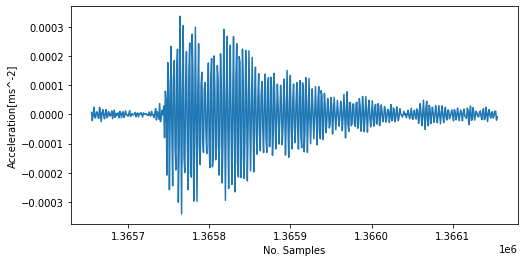

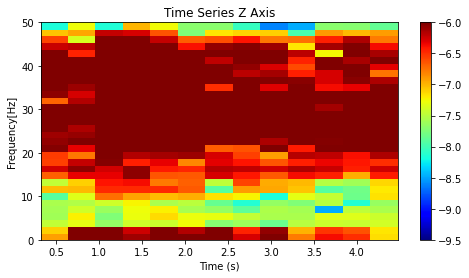

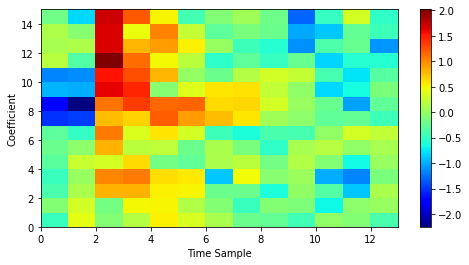

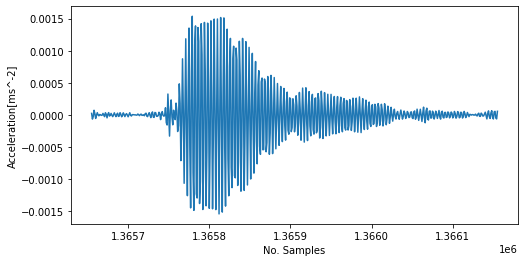

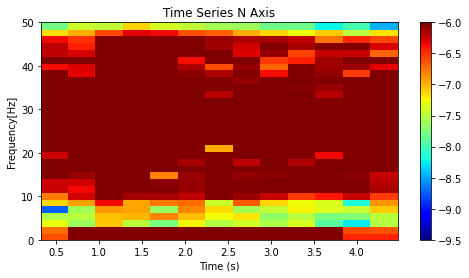

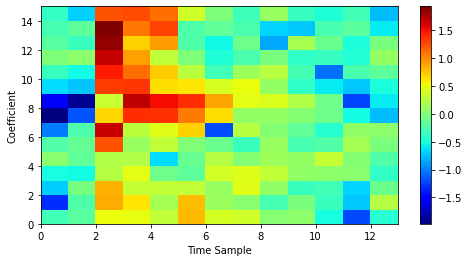

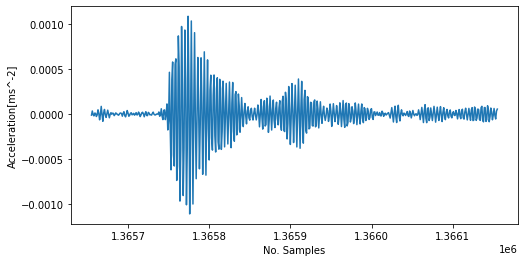

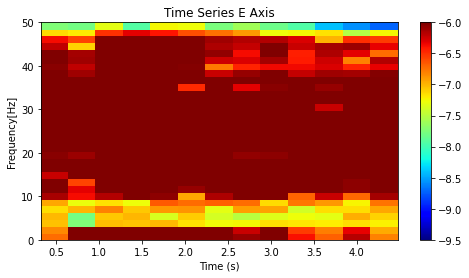

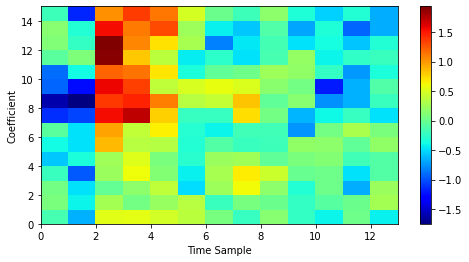

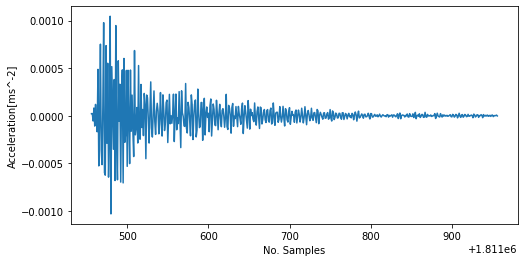

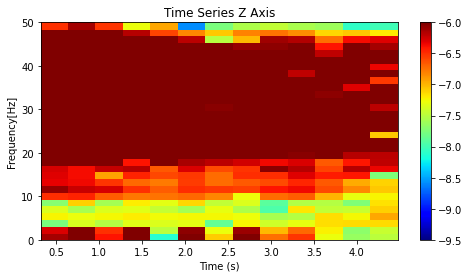

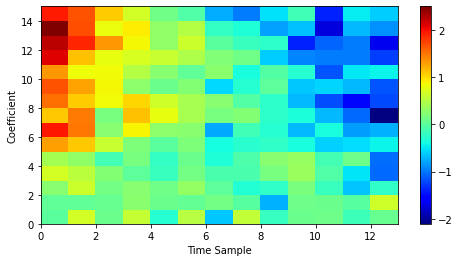

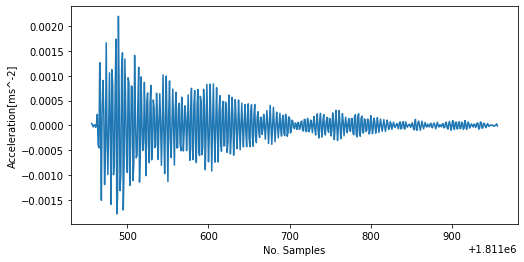

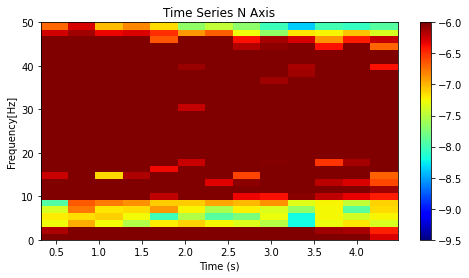

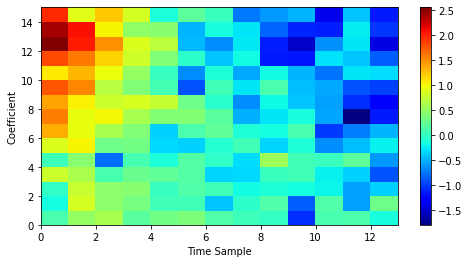

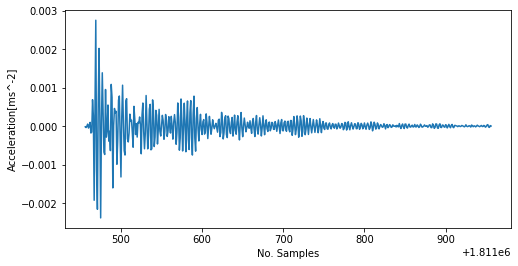

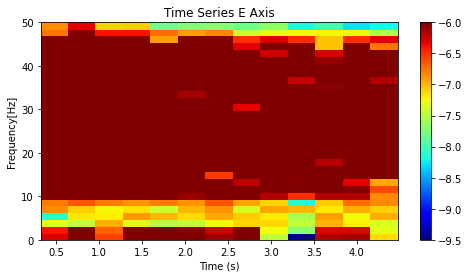

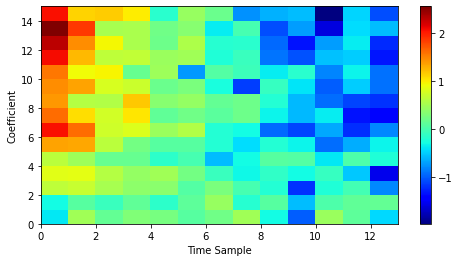

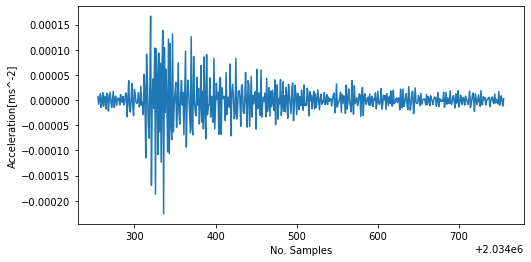

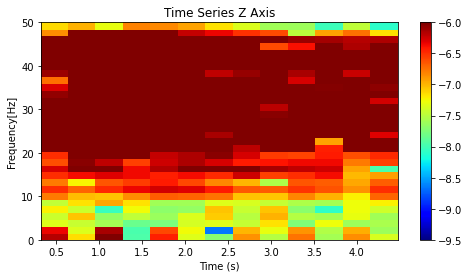

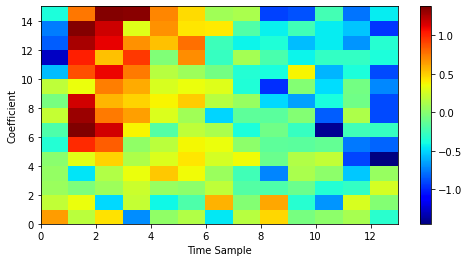

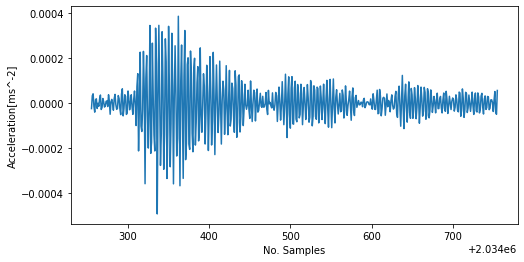

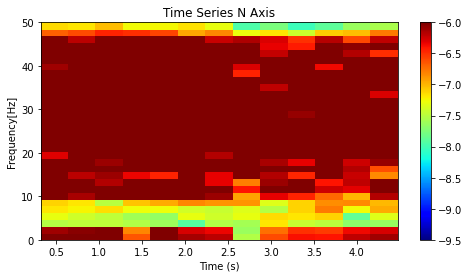

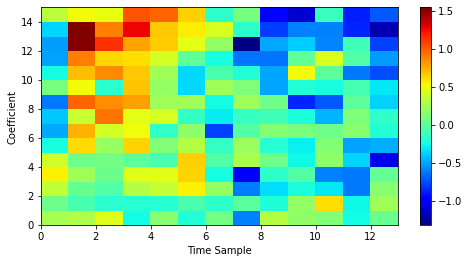

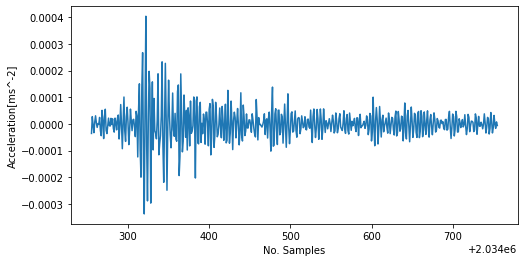

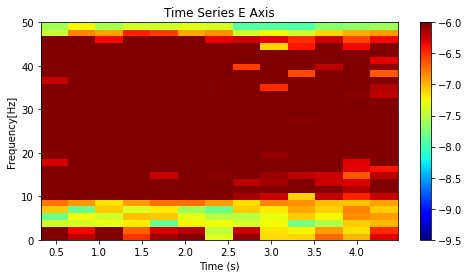

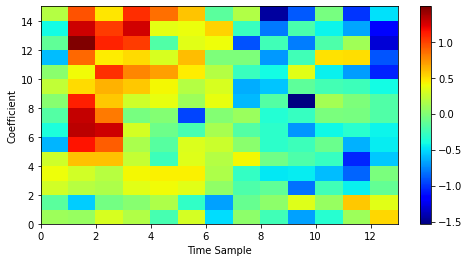

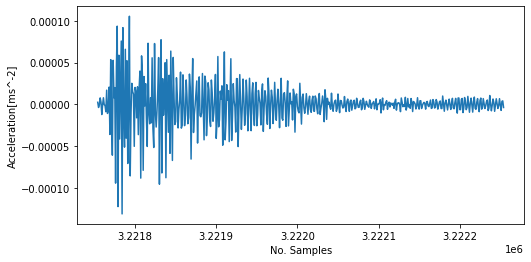

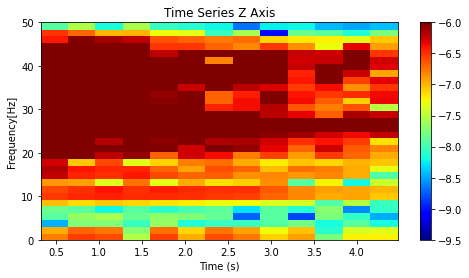

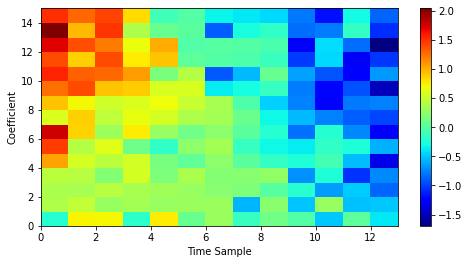

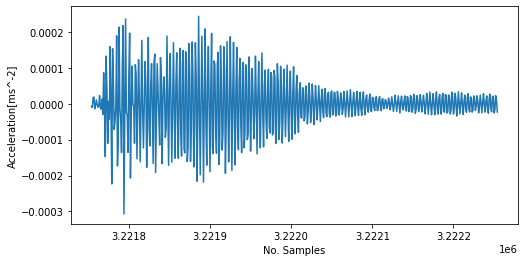

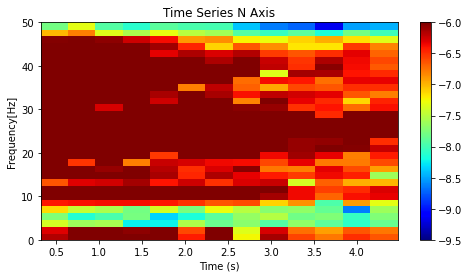

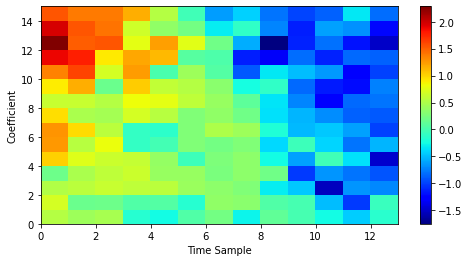

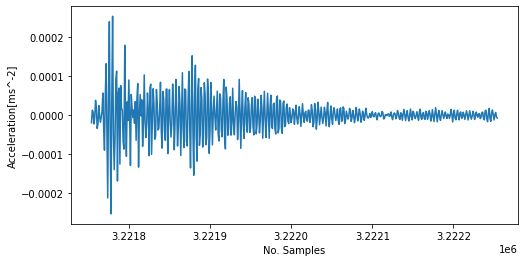

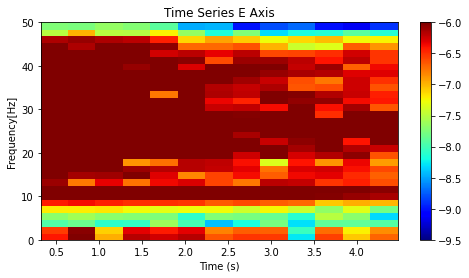

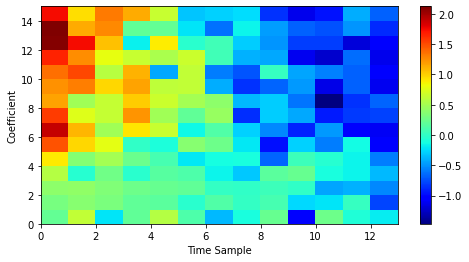

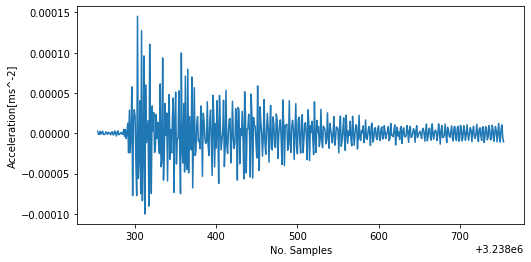

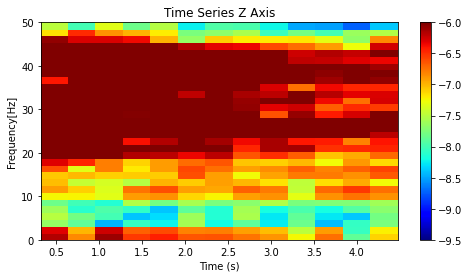

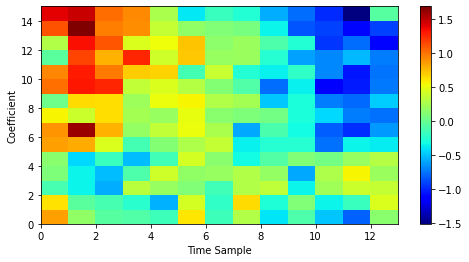

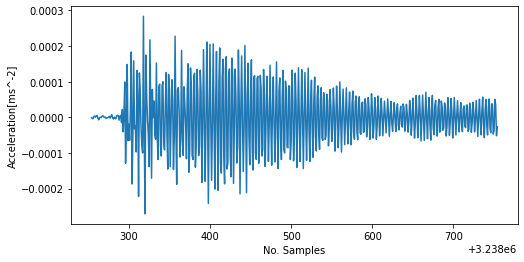

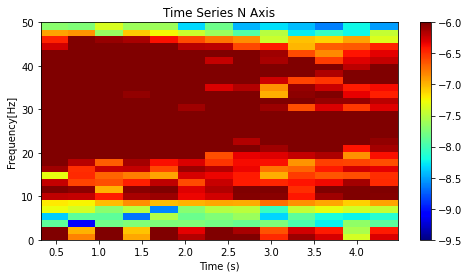

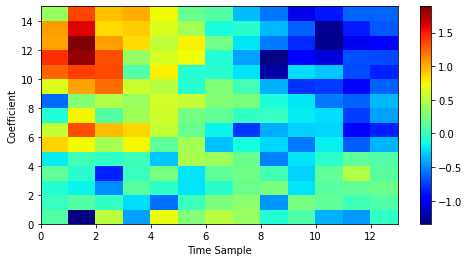

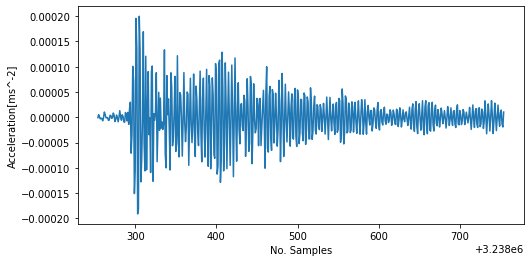

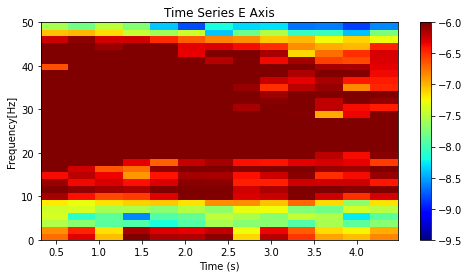

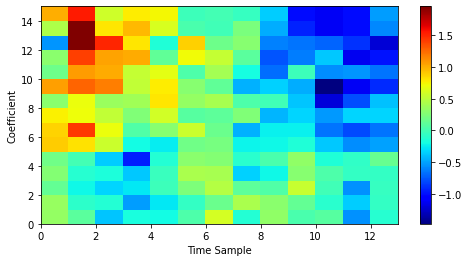

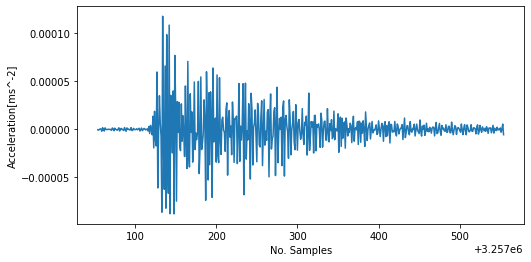

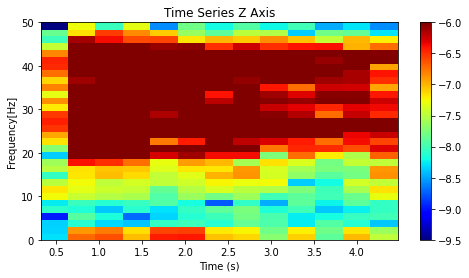

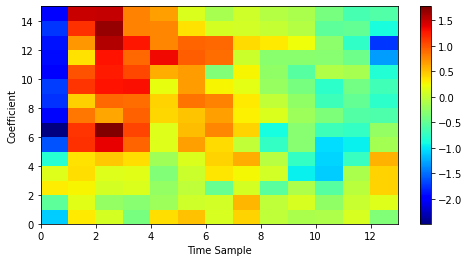

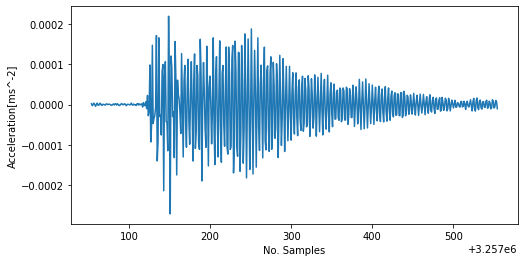

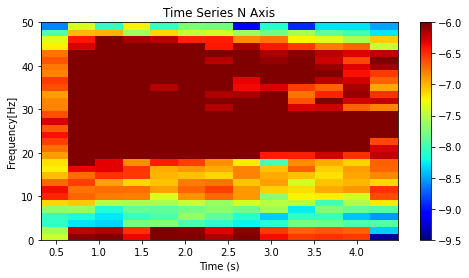

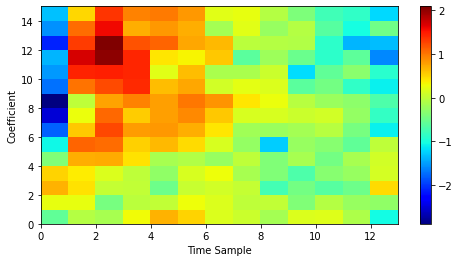

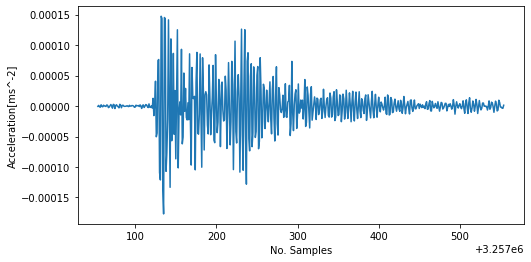

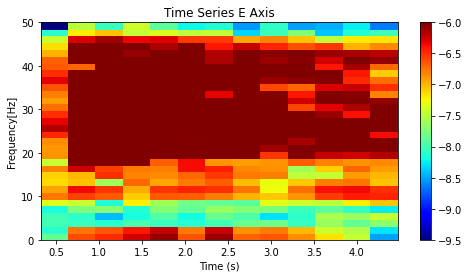

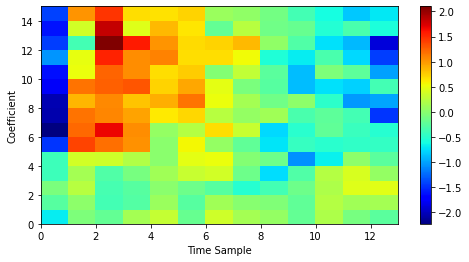

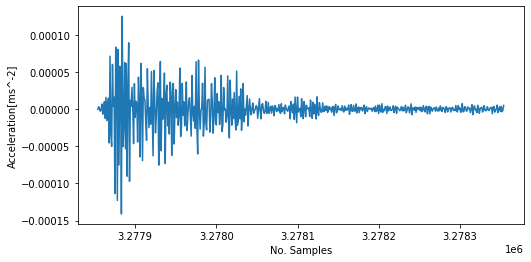

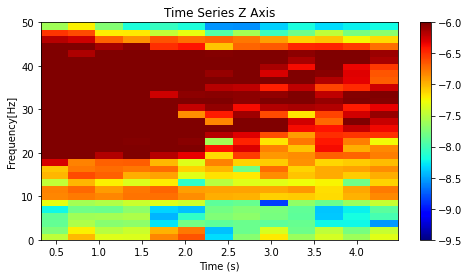

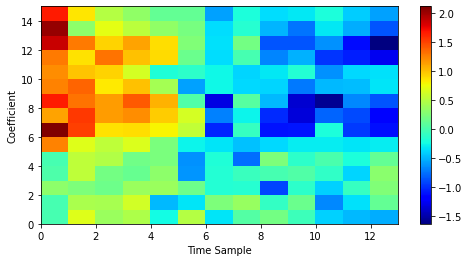

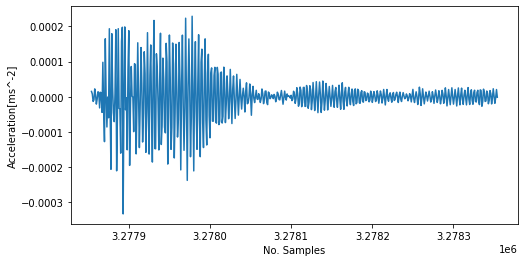

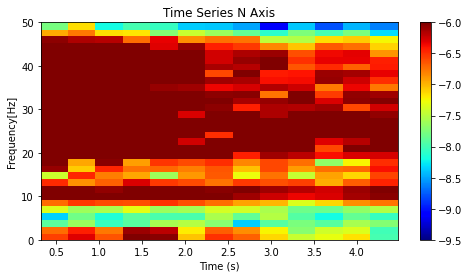

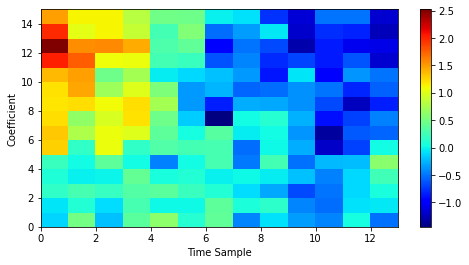

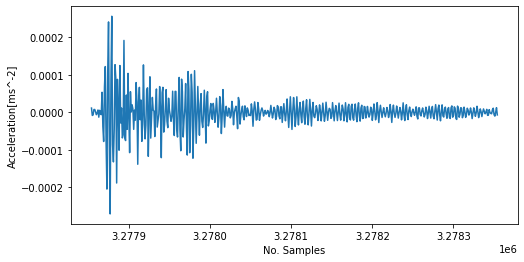

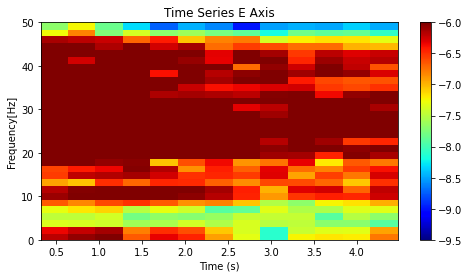

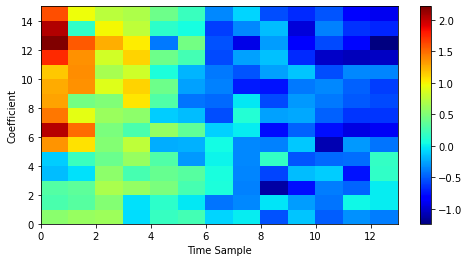

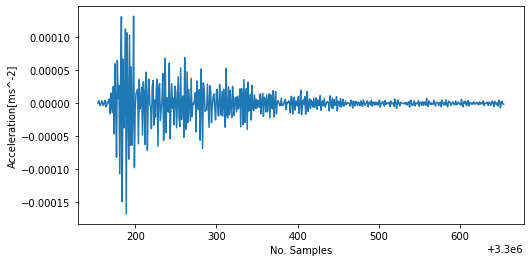

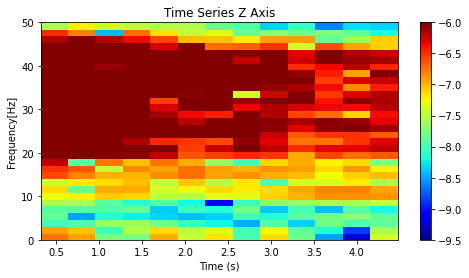

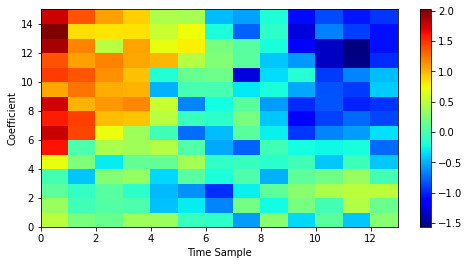

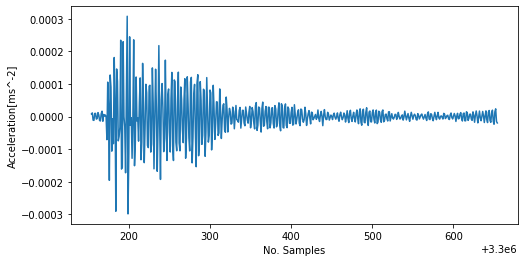

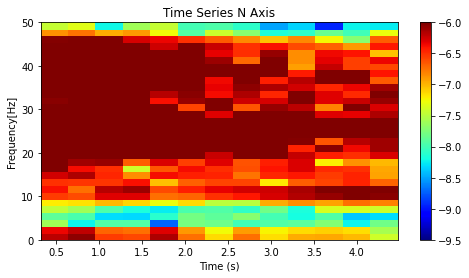

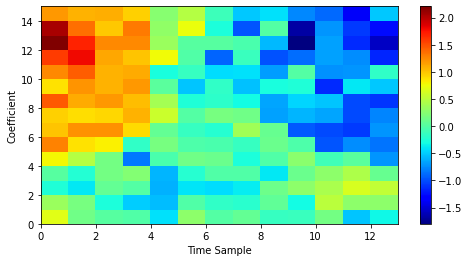

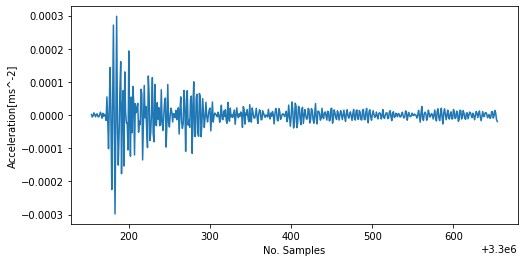

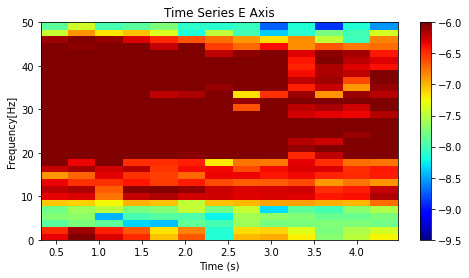

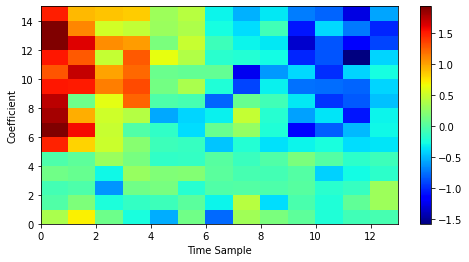

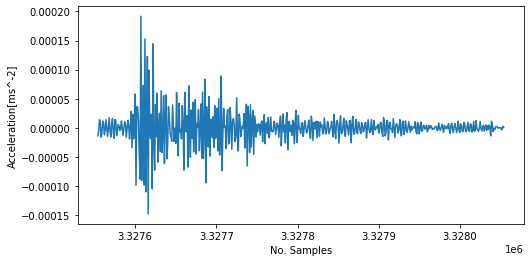

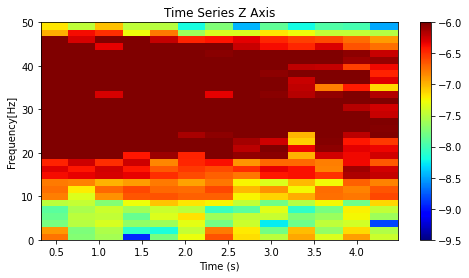

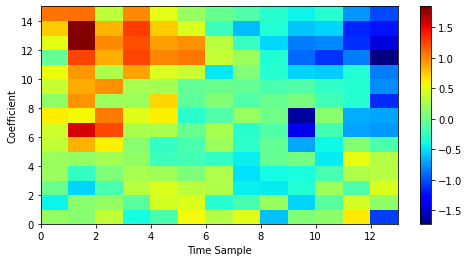

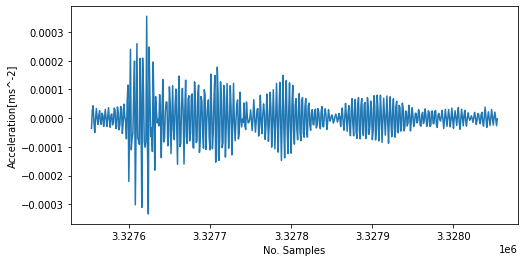

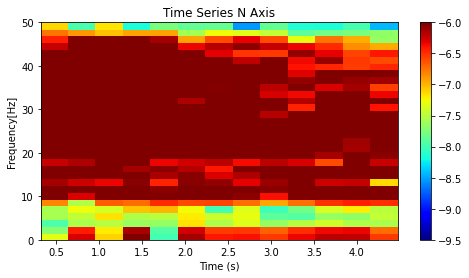

KeyboardInterrupt: ignored

In [0]:
N = len(donk_data)
res = [[[None],[None],[None]] for i in range(N)]
for i,d in enumerate(donk_data):
  for j,ax in enumerate(d):
    donk_data[i][ax] -= np.mean(donk_data[i][ax])
    A = plot_graphs(donk_data[i],ax,64,plot=True)
    fbank_coeffs = get_coeffs(A,f_bins=64,corr=True,normalize=True)
    #plot_mfcc(fbank_coeffs)
    #mfcc = delta(fbank_coeffs)
    #mfcc = delta(mfcc)
    res[i][j] = fbank_coeffs
    plot_coeffs(fbank_coeffs)
res = np.array(res)
print(res.shape)

Get Energy Ratio features:

In [0]:
donk_ratios = np.zeros(shape=(len(donk_data),3,3))
neg_ratios = np.zeros(shape=(len(neg_data),3,3))

for i,d in enumerate(donk_data):
  for j,ax in enumerate(d):
    for k in range(3):
      f,pxx = signal.periodogram(d[ax][k*500:(k*500)+500],100,'hann')
      #pxx = 10*np.log10(pxx)
      low_energy = sum(pxx[:51])
      high_energy = sum(pxx[51:])
      donk_ratios[i][j][k] = np.log10(high_energy/low_energy)
print(donk_ratios.shape)

for i,d in enumerate(neg_data):
  for j,ax in enumerate(d):
    for k in range(3):
      f,pxx = signal.periodogram(d[ax][k*500:(k*500)+500],100,'hann')
      #pxx = 10*np.log10(pxx)
      low_energy = sum(pxx[:51])
      high_energy = sum(pxx[51:])
      neg_ratios[i][j][k] = np.log10(high_energy/low_energy)
print(neg_ratios.shape)

res = np.concatenate([neg_ratios,donk_ratios])
print(res.shape)

(16, 3, 3)
(16, 3, 3)
(32, 3, 3)


Get HHT features:

In [0]:
N = len(feature_data)
res = [[[None],[None],[None]] for i in range(N)]
for i,d in enumerate(feature_data):
  for j,ax in enumerate(d):
    decomposer = emd.EMD(d[ax])
    imfs = decomposer.decompose()
    print('Orthogonality before = ', decomposer.io())
    oimfs = orthogonal_emd(imfs)
    print('Orthogonality after = ', IOt(oimfs,d[ax]))
    oimfs = oimfs[1:]
    corrs = get_corr(d[ax],oimfs)
    thresh = get_threshold(corrs)
    res_imfs = filter_imfs(corrs,thresh,oimfs)
    print('Number of IMFS = ', len(res_imfs))
    A,f,t = hht(res_imfs,100)
    fbank_coeffs = get_coeffs(A,corr=False)
    v = delta(fbank_coeffs)
    a = delta(v)
    res[i][j] = np.concatenate((fbank_coeffs,v,a),axis = 1)
    #res[i][j] = fbank_coeffs
    print('')
res = np.array(res)

Orthogonality before =  0.0009485702705306375
Orthogonality after =  7.0897512487225485e-19
Number of IMFS =  1

Orthogonality before =  0.02991862587372993
Orthogonality after =  8.300021656184953e-18
Number of IMFS =  1

Orthogonality before =  0.010464659724399394
Orthogonality after =  1.1969214356618735e-17
Number of IMFS =  2

Orthogonality before =  0.0008481477224690737
Orthogonality after =  3.7475031554048906e-19
Number of IMFS =  1

Orthogonality before =  0.00381609418033846
Orthogonality after =  9.343589577430978e-18
Number of IMFS =  1

Orthogonality before =  0.006592190058325115
Orthogonality after =  1.3019022880103306e-17
Number of IMFS =  2

Orthogonality before =  0.0009447424939519489
Orthogonality after =  5.006409787679803e-19
Number of IMFS =  1

Orthogonality before =  0.006174326436008914
Orthogonality after =  3.4496809438598792e-18
Number of IMFS =  1

Orthogonality before =  0.00938388731973803
Orthogonality after =  5.502388733979924e-18
Number of IMFS = 

/usr/local/lib/python3.6/dist-packages/pyhht/emd.py:368: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  "Maximum iteration limit reached.")



Orthogonality before =  0.03547727391113602
Orthogonality after =  9.784961707066096e-18
Number of IMFS =  2

Orthogonality before =  0.0013529453976513148
Orthogonality after =  7.963338217902261e-19
Number of IMFS =  1

Mode 9, Iteration 600
0 minima > 0; 4 maxima < 0.
Orthogonality before =  0.028480541766601895
Orthogonality after =  3.431122033219373e-17
Number of IMFS =  1

Orthogonality before =  0.008343537269135393
Orthogonality after =  4.14778576933018e-18
Number of IMFS =  1

Orthogonality before =  0.0004455715213264215
Orthogonality after =  5.384255831561568e-19
Number of IMFS =  1

Orthogonality before =  0.021436557391526376
Orthogonality after =  6.56824763891919e-18
Number of IMFS =  1

Orthogonality before =  0.003267466984805771
Orthogonality after =  1.8186290653600397e-18
Number of IMFS =  1

Orthogonality before =  0.0011670589112501462
Orthogonality after =  9.388620529685579e-19
Number of IMFS =  2

Mode 10, Iteration 600
0 minima > 0; 2 maxima < 0.
Orthogona

Get raw time series features:

In [0]:
def normalize(data):
  for i,s in enumerate(data):
    for j,ax in enumerate(s):
      data[i][j] -= np.mean(data[i][j])
  return data

res = [None]*len(feature_data)
for i,s in enumerate(feature_data):
  res[i] = s.to_numpy().T
res = np.array(res)
res = normalize(res)
print(res.shape)

(138, 3, 1501)


#Save to Memory

A quick check to see if the result looks right:

In [0]:
print(res.shape)
print(target_data.shape)

(138, 3, 1500, 39)


Save the features:

In [0]:
def write_file(data, file):
  directory = '/content/drive/My Drive/FYP/FYPdata/'+file
  np.save(directory,data)
  print('DONE!')

In [0]:
write_file(res,'Feature/1500/Feature Set 98 energy_ratios')

DONE!
